# Core

> Lisette Core

In [ ]:
#| default_exp core

In [ ]:
#| hide
from cachy import enable_cachy,disable_cachy

In [ ]:
#| hide
enable_cachy()

In [ ]:
#| export
import asyncio, base64, json, litellm, mimetypes, random, string
from typing import Optional,Callable
from html import escape
from litellm import (acompletion, completion, stream_chunk_builder, Message,
                     ModelResponse, ModelResponseStream, get_model_info, register_model, Usage)
from litellm.utils import function_to_dict, StreamingChoices, Delta, ChatCompletionMessageToolCall, Function, Choices
from toolslm.funccall import mk_ns, call_func, call_func_async, get_schema
from fastcore.utils import *
from fastcore.meta import delegates
from fastcore import imghdr
from dataclasses import dataclass

In [ ]:
#| hide
from fastcore.test import *
from IPython.display import Markdown, Image, Audio, Video
import httpx

# LiteLLM

## Deterministic outputs

LiteLLM `ModelResponse(Stream)` objects have `id` and `created_at` fields that are generated dynamically. Even when we use [`cachy`](https://github.com/answerdotai/cachy) to cache the LLM response these dynamic fields create diffs which makes code review more challenging. The patches below ensure that `id` and `created_at` fields are fixed and won't generate diffs.

In [ ]:
#| export
def patch_litellm(seed=0):
    "Patch litellm.ModelResponseBase such that `id` and `created` are fixed."
    from litellm.types.utils import ModelResponseBase
    @patch
    def __init__(self: ModelResponseBase, id=None, created=None, *args, **kwargs): 
        self._orig___init__(id='chatcmpl-xxx', created=1000000000, *args, **kwargs)

    @patch
    def __setattr__(self: ModelResponseBase, name, value):
        if name == 'id': value = 'chatcmpl-xxx'
        elif name == 'created': value = 1000000000
        self._orig___setattr__(name, value)

    if seed is not None: random.seed(seed) # ensures random ids like tool call ids are deterministic

In [ ]:
patch_litellm()

## Completion

LiteLLM provides an convenient unified interface for most big LLM providers. Because it's so useful to be able to switch LLM providers with just one argument. We want to make it even easier to by adding some more convenience functions and classes. 

This is very similar to our other wrapper libraries for popular AI providers: [claudette](https://claudette.answer.ai/) (Anthropic), [gaspard](https://github.com/AnswerDotAI/gaspard) (Gemini), [cosette](https://answerdotai.github.io/cosette/) (OpenAI).

In [ ]:
#| export
@patch
def _repr_markdown_(self: litellm.ModelResponse):
    message = self.choices[0].message
    content = ''
    if mc:=message.content: content += mc[0]['text'] if isinstance(mc,list) else mc
    if message.tool_calls:
        tool_calls = [f"\n\n🔧 {nested_idx(tc,'function','name')}({nested_idx(tc,'function','arguments')})\n" for tc in message.tool_calls]
        content += "\n".join(tool_calls)
    if not content: content = str(message)
    details = [
        f"id: `{self.id}`",
        f"model: `{self.model}`",
        f"finish_reason: `{self.choices[0].finish_reason}`"
    ]
    if hasattr(self, 'usage') and self.usage: details.append(f"usage: `{self.usage}`")
    det_str = '\n- '.join(details)
    
    return f"""{content}

<details>

- {det_str}

</details>"""

In [ ]:
#| export
register_model({
    "claude-opus-4-5": {
        "litellm_provider": "anthropic", "mode": "chat",
        "max_tokens": 64000, "max_input_tokens": 200000, "max_output_tokens": 64000,
        "input_cost_per_token": 0.000005, "output_cost_per_token": 0.000025,
        "cache_creation_input_token_cost": 0.000005*1.25, "cache_read_input_token_cost": 0.000005*0.1,
        "supports_function_calling": True, "supports_parallel_function_calling": True,
        "supports_vision": True, "supports_prompt_caching": True, "supports_response_schema": True,
        "supports_system_messages": True, "supports_reasoning": True, "supports_assistant_prefill": True,
        "supports_tool_choice": True, "supports_computer_use": True, "supports_web_search": True
    }
});
sonn45 = "claude-sonnet-4-5"
opus45 = "claude-opus-4-5"

In [ ]:
# litellm._turn_on_debug()

In [ ]:
ms = ["gemini/gemini-3-pro-preview", "gemini/gemini-2.5-pro", "gemini/gemini-2.5-flash", "claude-sonnet-4-5", "openai/gpt-4.1"]
msg = [{'role':'user','content':'Hey there!', 'cache_control': {'type': 'ephemeral'}}]
for m in ms:
    display(Markdown(f'**{m}:**'))
    display(completion(m,msg))

**gemini/gemini-3-pro-preview:**

Hello! How can I help you today?

Whether you need help with a creative project, have a burning question, or just want to chat, I'm all ears. What's on your mind?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=163, prompt_tokens=4, total_tokens=167, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=120, rejected_prediction_tokens=None, text_tokens=43, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None))`

</details>

**gemini/gemini-2.5-pro:**

Hey there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=1051, prompt_tokens=4, total_tokens=1055, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=1041, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None))`

</details>

**gemini/gemini-2.5-flash:**

Hey there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=896, prompt_tokens=4, total_tokens=900, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=886, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None))`

</details>

**claude-sonnet-4-5:**

Hello! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=12, prompt_tokens=10, total_tokens=22, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**

Hey! How can I help you today? 😊

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=10, prompt_tokens=10, total_tokens=20, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

## Messages formatting

Let's start with making it easier to pass messages into litellm's `completion` function (including images, and pdf files).

In [ ]:
#| export
#| export
def _bytes2content(data):
    "Convert bytes to litellm content dict (image, pdf, audio, video)"
    mtype = detect_mime(data)
    if not mtype: raise ValueError(f'Data must be a supported file type, got {data[:10]}')
    encoded = base64.b64encode(data).decode("utf-8")    
    if mtype.startswith('image/'): return {'type': 'image_url', 'image_url': f'data:{mtype};base64,{encoded}'}
    return {'type': 'file', 'file': {'file_data': f'data:{mtype};base64,{encoded}'}}

In [ ]:
#| export
def _add_cache_control(msg,          # LiteLLM formatted msg
                       ttl=None):    # Cache TTL: '5m' (default) or '1h'
    "cache `msg` with default time-to-live (ttl) of 5minutes ('5m'), but can be set to '1h'."
    if isinstance(msg["content"], str): 
        msg["content"] = [{"type": "text", "text": msg["content"]}]
    cache_control = {"type": "ephemeral"}
    if ttl is not None: cache_control["ttl"] = ttl
    if isinstance(msg["content"], list) and msg["content"]:
        msg["content"][-1]["cache_control"] = cache_control
    return msg

def _has_cache(msg):
    return msg["content"] and isinstance(msg["content"], list) and ('cache_control' in msg["content"][-1])

def remove_cache_ckpts(msg):
    "remove cache checkpoints and return msg."
    if _has_cache(msg): msg["content"][-1].pop('cache_control', None)
    return msg

def _mk_content(o):
    if isinstance(o, str): return {'type':'text','text':o.strip() or '.'}
    elif isinstance(o,bytes): return _bytes2content(o)
    return o

def contents(r):
    "Get message object from response `r`."
    return r.choices[0].message

In [ ]:
#| export
def mk_msg(
    content,      # Content: str, bytes (image), list of mixed content, or dict w 'role' and 'content' fields
    role="user",  # Message role if content isn't already a dict/Message
    cache=False,  # Enable Anthropic caching
    ttl=None      # Cache TTL: '5m' (default) or '1h'
):
    "Create a LiteLLM compatible message."
    if isinstance(content, dict) or isinstance(content, Message): return content
    if isinstance(content, ModelResponse): return contents(content)
    if isinstance(content, list) and len(content) == 1 and isinstance(content[0], str): c = content[0]
    elif isinstance(content, list): c = [_mk_content(o) for o in content]
    else: c = content
    msg = {"role": role, "content": c}
    return _add_cache_control(msg, ttl=ttl) if cache else msg

Now we can use mk_msg to create different types of messages.

Simple text:

In [ ]:
msg = mk_msg("hey")
msg

{'role': 'user', 'content': 'hey'}

Which can be passed to litellm's `completion` function like this:

In [ ]:
model = ms[1] # use 2.5-pro, 3-pro is very slow even to run tests as of making

In [ ]:
res = completion(model, [msg])
res

Hey there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=767, prompt_tokens=2, total_tokens=769, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=757, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=2, image_tokens=None))`

</details>

We'll add a little shortcut to make examples and testing easier here:

In [ ]:
def c(msgs, m=model, **kw):
    msgs = [msgs] if isinstance(msgs,dict) else listify(msgs)
    return completion(m, msgs, **kw)

In [ ]:
c(msg)

Hey there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=767, prompt_tokens=2, total_tokens=769, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=757, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=2, image_tokens=None))`

</details>

Lists w just one string element are flattened for conciseness:

In [ ]:
test_eq(mk_msg("hey"), mk_msg(["hey"]))

(LiteLLM ignores these fields when sent to other providers)

Text and images:

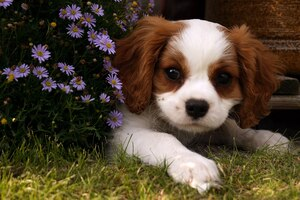

In [ ]:
img_fn = Path('samples/puppy.jpg')
Image(filename=img_fn, width=200)

In [ ]:
msg = mk_msg(['hey what in this image?',img_fn.read_bytes()])
print(json.dumps(msg,indent=1)[:200]+"...")

{
 "role": "user",
 "content": [
  {
   "type": "text",
   "text": "hey what in this image?"
  },
  {
   "type": "image_url",
   "image_url": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/4gxUSU...


In [ ]:
c(msg)

This is an absolutely adorable picture of a puppy!

Here's a breakdown of what's in the image:

*   **The Puppy:** The main subject is a very young puppy, most likely a **Cavalier King Charles Spaniel**. It has the breed's characteristic features: large, dark, expressive eyes, long, floppy ears with silky, wavy fur, and a sweet expression. The coloring, white with chestnut or reddish-brown patches, is known as "Blenheim" in this breed.
*   **The Pose:** The puppy is lying down in the green grass, peeking out from behind a bush of flowers. It's looking directly at the camera with a curious and gentle gaze.
*   **The Flowers:** To the left of the puppy is a cluster of small, delicate purple or lavender-colored flowers, which look like asters or a similar daisy-like flower.
*   **The Setting:** The scene is outdoors, likely in a garden or yard. The focus is sharp on the puppy, while the background is softly blurred, which makes the puppy stand out as the main subject.

Overall, it's a very charming and heartwarming photograph capturing the innocence and cuteness of a young puppy.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=1332, prompt_tokens=265, total_tokens=1597, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=1075, rejected_prediction_tokens=None, text_tokens=257, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=7, image_tokens=None))`

</details>

Let's also demonstrate this for PDFs

In [ ]:
# TODO this gave me an error (jph Nov 30)
# pdf_fn = Path('samples/solveit.pdf')
# msg = mk_msg(['Who is the author of this pdf?', pdf_fn.read_bytes()])
# c(msg)

Some models like Gemini support audio and video:

In [ ]:
wav_data = httpx.get("https://openaiassets.blob.core.windows.net/$web/API/docs/audio/alloy.wav").content
# Audio(wav_data)  # uncomment to preview

In [ ]:
msg = mk_msg(['What is this audio saying?', wav_data])
completion(ms[1], [msg])

The audio says: "The sun rises in the east and sets in the west. This simple fact has been observed by humans for thousands of years."

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=351, prompt_tokens=230, total_tokens=581, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=321, rejected_prediction_tokens=None, text_tokens=30, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=223, cached_tokens=None, text_tokens=7, image_tokens=None))`

</details>

In [ ]:
vid_data = httpx.get("https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/pixel8.mp4").content

In [ ]:
msg = mk_msg(['Concisely, what is happening in this video?', vid_data])
completion(ms[1], [msg])

This video is an advertisement for the Google Pixel 8 Pro smartphone, featuring a photographer named Saeka Shimada. She walks through Tokyo at night, demonstrating the phone's new "Video Boost" feature, which uses "Night Sight" to capture high-quality, vibrant video in low-light conditions. She is visibly impressed by the clarity and beauty of the footage she records in the city's atmospheric alleys.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=402, prompt_tokens=17402, total_tokens=17804, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=318, rejected_prediction_tokens=None, text_tokens=84, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=1873, cached_tokens=None, text_tokens=12, image_tokens=None))`

</details>

### Caching

Some providers such as Anthropic require manually opting into caching. Let's try it:

In [ ]:
def cpr(i): return f'{i} '*1024 + 'This is a caching test. Report back only what number you see repeated above.'

In [ ]:
#| eval: false
disable_cachy()

In [ ]:
# msg = mk_msg(cpr(1), cache=True)
# res = c(msg, ms[2])
# res

Anthropic has a maximum of 4 cache checkpoints, so we remove previous ones as we go:

In [ ]:
# res = c([remove_cache_ckpts(msg), mk_msg(res), mk_msg(cpr(2), cache=True)], ms[2])
# res

We see that the first message was cached, and this extra message has been written to cache:

In [ ]:
# res.usage.prompt_tokens_details

We can add a bunch of large messages in a loop to see how the number of cached tokens used grows.

We do this for 25 times to ensure it still works for more than >20 content blocks, [which is a known anthropic issue](https://docs.claude.com/en/docs/build-with-claude/prompt-caching).

The code below is commented by default, because it's slow. Please uncomment when working on caching.

In [ ]:
# h = []
# msg = mk_msg(cpr(1), cache=True)

# for o in range(2,25):
#     h += [remove_cache_ckpts(msg), mk_msg(res)]
#     msg = mk_msg(cpr(o), cache=True)
#     res = c(h+[msg])
#     detls = res.usage.prompt_tokens_details
#     print(o, detls.cached_tokens, detls.cache_creation_tokens, end='; ')

In [ ]:
enable_cachy()

### Reconstructing formatted outputs

Lisette can call multiple tools in a loop. Further down this notebook, we'll provide convenience functions for formatting such a sequence of toolcalls and responses into one formatted output string.

For now, we'll show an example and show how to transform such a formatted output string back into a valid LiteLLM history.

In [ ]:
fmt_outp = '''
I'll solve this step-by-step, using parallel calls where possible.

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",
  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },
  "result": "15"
}
```

</details>

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",
  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },
  "result": "3"
}
```

</details>

Now I need to multiply 15 * 3 before I can do the final division:

<details class='tool-usage-details'>

```json
{
  "id": "toolu_0141NRaWUjmGtwxZjWkyiq6C",
  "call": { "function": "multiply", "arguments": { "a": 15, "b": 3 } },
  "result": "45"
}
```

</details>
'''

In [ ]:
#| export
detls_tag = "<details class='tool-usage-details'>"
re_tools = re.compile(fr"^({detls_tag}\n+```json\n+(.*?)\n+```\n+</details>)", flags=re.DOTALL|re.MULTILINE)

We can split into chunks of (text,toolstr,json):

In [ ]:
sp = re_tools.split(fmt_outp)
for o in list(chunked(sp, 3, pad=True)): print('- ', o)

-  ["\nI'll solve this step-by-step, using parallel calls where possible.\n\n", '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",\n  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },\n  "result": "15"\n}\n```\n\n</details>', '{\n  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",\n  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },\n  "result": "15"\n}']
-  ['\n\n', '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",\n  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },\n  "result": "3"\n}\n```\n\n</details>', '{\n  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",\n  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },\n  "result": "3"\n}']
-  ['\n\nNow I need to multiply 15 * 3 before I can do the final division:\n\n', '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_0141NRaWUjmGtwxZjWkyiq6C",\n  "call": { "func

In [ ]:
#| export
def _extract_tool(text:str)->tuple[dict,dict]:
    "Extract tool call and results from <details> block"
    d = json.loads(text.strip())
    call = d['call']
    func = call['function']
    tc = ChatCompletionMessageToolCall(Function(dumps(call['arguments']),func), d['id'])
    tr = {'role': 'tool','tool_call_id': d['id'],'name': func, 'content': d['result']}
    return tc,tr

def fmt2hist(outp:str)->list:
    "Transform a formatted output into a LiteLLM compatible history"
    lm,hist = Message(),[]
    spt = re_tools.split(outp)
    for txt,_,tooljson in chunked(spt, 3, pad=True):
        txt = txt.strip() if tooljson or txt.strip() else '.'
        hist.append(lm:=Message(txt))
        if tooljson:
            tcr = _extract_tool(tooljson)
            if not hist: hist.append(lm) # if LLM calls a tool without talking
            lm.tool_calls = lm.tool_calls+[tcr[0]] if lm.tool_calls else [tcr[0]] 
            hist.append(tcr[1])
    return hist

See how we can turn that one formatted output string back into a list of Messages:

In [ ]:
from pprint import pprint

In [ ]:
h = fmt2hist(fmt_outp)
pprint(h)

[Message(content="I'll solve this step-by-step, using parallel calls where possible.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":10,"b":5}', name='simple_add'), id='toolu_01KjnQH2Nsz2viQ7XYpLW3Ta', type='function')], function_call=None, provider_specific_fields=None),
 {'content': '15',
  'name': 'simple_add',
  'role': 'tool',
  'tool_call_id': 'toolu_01KjnQH2Nsz2viQ7XYpLW3Ta'},
 Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":2,"b":1}', name='simple_add'), id='toolu_01Koi2EZrGZsBbnQ13wuuvzY', type='function')], function_call=None, provider_specific_fields=None),
 {'content': '3',
  'name': 'simple_add',
  'role': 'tool',
  'tool_call_id': 'toolu_01Koi2EZrGZsBbnQ13wuuvzY'},
 Message(content='Now I need to multiply 15 * 3 before I can do the final division:', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":15,"b":3}', name='

### `mk_msgs`

We will skip tool use blocks and tool results during caching

In [ ]:
#| export
def _apply_cache_idxs(msgs, cache_idxs=[-1], ttl=None):
    'Add cache control to idxs after filtering tools'
    ms = L(msgs).filter(lambda m: not (m.get('tool_calls', []) or m['role'] == 'tool'))
    for i in cache_idxs:
        try: _add_cache_control(ms[i], ttl)
        except IndexError: continue

Now lets make it easy to provide entire conversations:

In [ ]:
#| export
def mk_msgs(
    msgs,                   # List of messages (each: str, bytes, list, or dict w 'role' and 'content' fields)
    cache=False,            # Enable Anthropic caching
    cache_idxs=[-1],        # Cache breakpoint idxs
    ttl=None,               # Cache TTL: '5m' (default) or '1h'
):
    "Create a list of LiteLLM compatible messages."
    if not msgs: return []
    if not isinstance(msgs, list): msgs = [msgs]
    res,role = [],'user'
    msgs = L(msgs).map(lambda m: fmt2hist(m) if detls_tag in m else [m]).concat()
    for m in msgs:
        res.append(msg:=remove_cache_ckpts(mk_msg(m, role=role)))
        role = 'assistant' if msg['role'] in ('user','function', 'tool') else 'user'
    if cache: _apply_cache_idxs(res, cache_idxs, ttl)
    return res

With `mk_msgs` you can easily provide a whole conversation:

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm doing fine and you?"])
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant', 'content': "I'm doing fine and you?"}]

By defualt the last message will be cached when `cache=True`:

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm doing fine and you?"], cache=True)
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': "I'm doing fine and you?",
    'cache_control': {'type': 'ephemeral'}}]}]

In [ ]:
test_eq('cache_control' in msgs[-1]['content'][0], True)

Alternatively, users can provide custom `cache_idxs`. Tool call blocks and results are skipped during caching:

In [ ]:
msgs = mk_msgs(['Hello!','Hi! How can I help you?','Call some functions!',fmt_outp], cache=True, cache_idxs=[0,-2,-1])
msgs

[{'role': 'user',
  'content': [{'type': 'text',
    'text': 'Hello!',
    'cache_control': {'type': 'ephemeral'}}]},
 {'role': 'assistant', 'content': 'Hi! How can I help you?'},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Call some functions!',
    'cache_control': {'type': 'ephemeral'}}]},
 Message(content="I'll solve this step-by-step, using parallel calls where possible.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":10,"b":5}', name='simple_add'), id='toolu_01KjnQH2Nsz2viQ7XYpLW3Ta', type='function')], function_call=None, provider_specific_fields=None),
 {'role': 'tool',
  'tool_call_id': 'toolu_01KjnQH2Nsz2viQ7XYpLW3Ta',
  'name': 'simple_add',
  'content': '15'},
 Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":2,"b":1}', name='simple_add'), id='toolu_01Koi2EZrGZsBbnQ13wuuvzY', type='function')], function_call=None, provider_specific_fields=None),

In [ ]:
test_eq('cache_control' in msgs[0]['content'][0], True)
test_eq('cache_control' in msgs[2]['content'][0], True) # shifted idxs to skip tools
test_eq('cache_control' in msgs[-1]['content'][0], True)

Who's speaking at when is automatically inferred.
Even when there are multiple tools being called in parallel (which LiteLLM supports!).

In [ ]:
msgs = mk_msgs(['Tell me the weather in Paris and Rome',
                'Assistant calls weather tool two times',
                {'role':'tool','content':'Weather in Paris is ...'},
                {'role':'tool','content':'Weather in Rome is ...'},
                'Assistant returns weather',
                'Thanks!'])
msgs

[{'role': 'user', 'content': 'Tell me the weather in Paris and Rome'},
 {'role': 'assistant', 'content': 'Assistant calls weather tool two times'},
 {'role': 'tool', 'content': 'Weather in Paris is ...'},
 {'role': 'tool', 'content': 'Weather in Rome is ...'},
 {'role': 'assistant', 'content': 'Assistant returns weather'},
 {'role': 'user', 'content': 'Thanks!'}]

In [ ]:
#| hide
test_eq([m['role'] for m in msgs],['user','assistant','tool','tool','assistant','user'])

For ease of use, if `msgs` is not already in a `list`, it will automatically be wrapped inside one. This way you can pass a single prompt into `mk_msgs` and get back a LiteLLM compatible msg history.

In [ ]:
msgs = mk_msgs("Hey")
msgs

[{'role': 'user', 'content': 'Hey'}]

In [ ]:
#| hide
msgs = mk_msgs({'role':'tool','content':'fake tool result'})
msgs

[{'role': 'tool', 'content': 'fake tool result'}]

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm fine, you?"])
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant', 'content': "I'm fine, you?"}]

However, beware that if you use `mk_msgs` for a single message, consisting of multiple parts.
Then you should be explicit, and make sure to wrap those multiple messages in two lists:

1. One list to show that they belong together in one message (the inner list).
2. Another, because mk_msgs expects a list of multiple messages (the outer list).

This is common when working with images for example:

In [ ]:
msgs = mk_msgs([['Whats in this img?',img_fn.read_bytes()]])
print(json.dumps(msgs,indent=1)[:200]+"...")

[
 {
  "role": "user",
  "content": [
   {
    "type": "text",
    "text": "Whats in this img?"
   },
   {
    "type": "image_url",
    "image_url": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD...


## Streaming

LiteLLM supports streaming responses. That's really useful if you want to show intermediate results, instead of having to wait until the whole response is finished.

We create this helper function that returns the entire response at the end of the stream. This is useful when you want to store the whole response somewhere after having displayed the intermediate results.

In [ ]:
#| export
def stream_with_complete(gen, postproc=noop):
    "Extend streaming response chunks with the complete response"
    chunks = []
    for chunk in gen:
        chunks.append(chunk)
        yield chunk
    postproc(chunks)
    return stream_chunk_builder(chunks)

In [ ]:
r = c(mk_msgs("Hey!"), stream=True)
r2 = SaveReturn(stream_with_complete(r))

In [ ]:
for o in r2:
    cts = o.choices[0].delta.content
    if cts: print(cts, end='')

Hey there! How can I help you today?

In [ ]:
r2.value

Hey there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=818, prompt_tokens=3, total_tokens=821, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

## Tools

In [ ]:
#| export
def lite_mk_func(f):
    if isinstance(f, dict): return f
    return {'type':'function', 'function':get_schema(f, pname='parameters')}

In [ ]:
def simple_add(
    a: int,   # first operand
    b: int=0  # second operand
) -> int:
    "Add two numbers together"
    return a + b

In [ ]:
toolsc = lite_mk_func(simple_add)
toolsc

{'type': 'function',
 'function': {'name': 'simple_add',
  'description': 'Add two numbers together\n\nReturns:\n- type: integer',
  'parameters': {'type': 'object',
   'properties': {'a': {'type': 'integer', 'description': 'first operand'},
    'b': {'type': 'integer', 'description': 'second operand', 'default': 0}},
   'required': ['a']}}}

In [ ]:
tmsg = mk_msg("What is 5478954793+547982745? How about 5479749754+9875438979? Always use tools for calculations, and describe what you'll do before using a tool. Where multiple tool calls are required, do them in a single response where possible. ")
r = c(tmsg, tools=[toolsc])

In [ ]:
display(r)

I will use the `simple_add` tool to perform the two requested additions. First, I'll add 5478954793 and 547982745. Then, I'll add 5479749754 and 9875438979.

🔧 simple_add({"a": 5478954793, "b": 547982745})



🔧 simple_add({"b": 9875438979, "a": 5479749754})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=674, prompt_tokens=149, total_tokens=823, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=523, rejected_prediction_tokens=None, text_tokens=151, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=149, image_tokens=None))`

</details>

A tool response can be a string or a list of tool blocks (e.g., an image url block). To allow users to specify if a response should not be immediately stringified, we provide the ToolResponse datatype users can wrap their return statement in.

In [ ]:
#| export
@dataclass
class ToolResponse:
    content: list[str,str]

In [ ]:
#| export
def _lite_call_func(tc,ns,raise_on_err=True):
    try: fargs = json.loads(tc.function.arguments)
    except Exception as e: raise ValueError(f"Failed to parse function arguments: {tc.function.arguments}") from e
    res = call_func(tc.function.name, fargs,ns=ns)
    if isinstance(res, ToolResponse): res = res.content
    else: res = str(res)
    return {"tool_call_id": tc.id, "role": "tool", "name": tc.function.name, "content": res}

In [ ]:
tcs = [_lite_call_func(o, ns=globals()) for o in r.choices[0].message.tool_calls]
tcs

[{'tool_call_id': 'call_4ed59558dd1f4136881e73efed47',
  'role': 'tool',
  'name': 'simple_add',
  'content': '6026937538'},
 {'tool_call_id': 'call_422313a0783844a1b2779065365d',
  'role': 'tool',
  'name': 'simple_add',
  'content': '15355188733'}]

In [ ]:
def delta_text(msg):
    "Extract printable content from streaming delta, return None if nothing to print"
    c = msg.choices[0]
    if not c: return c
    if not hasattr(c,'delta'): return None #f'{c}'
    delta = c.delta
    if delta.content: return delta.content
    if delta.tool_calls:
        res = ''.join(f"🔧 {tc.function.name}" for tc in delta.tool_calls if tc.id and tc.function.name)
        if res: return f'\n{res}\n'
    if hasattr(delta,'reasoning_content'): return '🧠' if delta.reasoning_content else '\n\n'
    return None

In [ ]:
r = c(tmsg, stream=True, tools=[toolsc])
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')

I will add the two pairs of numbers for you. First, I'll add 5478954793 and 547982745. Then, I'll add 5479749754 and 9875438979.
🔧 simple_add
call:simple_add{a:5479749754,b:9875

In [ ]:
r2.value

I will add the two pairs of numbers for you. First, I'll add 5478954793 and 547982745. Then, I'll add 5479749754 and 9875438979.call:simple_add{a:5479749754,b:9875

🔧 simple_add({"a": 5478954793, "b": 547982745})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=288, prompt_tokens=149, total_tokens=437, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=25, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

In [ ]:
msg = mk_msg("Solve this complex math problem: What is the derivative of x^3 + 2x^2 - 5x + 1?")
r = c(msg, stream=True, reasoning_effort="low")
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')

🧠🧠🧠🧠

Of course! While it might seem complex at first, this is a classic calculus problem that becomes quite simple once you know the rules.

The derivative of **x³ + 2x² - 5x + 1** is:

**3x² + 4x - 5**

---

### Step-by-Step Solution:

To solve this, we use a few fundamental rules of differentiation. The main idea is that we can take the derivative of each part of the expression (each term) separately and then add them together.

The function is: `f(x) = x³ + 2x² - 5x + 1`

Let's break it down term by term.

#### 1. The Power Rule
The most important rule we'll use is the **Power Rule**, which states:
The derivative of `xⁿ` is `n * xⁿ⁻¹`
(In simple terms: bring the exponent down to the front as a multiplier, then subtract one from the original exponent).

---

**Term 1: `x³`**
*   Using the Power Rule, `n = 3`.
*   Bring the `3` to the front and subtract 1 from the exponent.
*   Derivative = `3 * x³⁻¹` = **3x²**

**Term 2: `2x²`**
*   We use the Power Rule on `x²` and keep the constant `2` 

Now, we just combine the derivatives of each term:

**3x² + 4x - 5 + 0**

Which simplifies to our final answer:

### **3x² + 4x - 5**

In [ ]:
r2.value

Of course! While it might seem complex at first, this is a classic calculus problem that becomes quite simple once you know the rules.

The derivative of **x³ + 2x² - 5x + 1** is:

**3x² + 4x - 5**

---

### Step-by-Step Solution:

To solve this, we use a few fundamental rules of differentiation. The main idea is that we can take the derivative of each part of the expression (each term) separately and then add them together.

The function is: `f(x) = x³ + 2x² - 5x + 1`

Let's break it down term by term.

#### 1. The Power Rule
The most important rule we'll use is the **Power Rule**, which states:
The derivative of `xⁿ` is `n * xⁿ⁻¹`
(In simple terms: bring the exponent down to the front as a multiplier, then subtract one from the original exponent).

---

**Term 1: `x³`**
*   Using the Power Rule, `n = 3`.
*   Bring the `3` to the front and subtract 1 from the exponent.
*   Derivative = `3 * x³⁻¹` = **3x²**

**Term 2: `2x²`**
*   We use the Power Rule on `x²` and keep the constant `2` as a multiplier.
*   The derivative of `x²` is `2 * x²⁻¹` = `2x`.
*   Now, multiply by the constant `2`: `2 * (2x)` = **4x**

**Term 3: `-5x`**
*   You can think of `x` as `x¹`.
*   Using the Power Rule, the derivative of `x¹` is `1 * x¹⁻¹` = `1 * x⁰`.
*   Anything to the power of 0 is 1, so the derivative is `1`.
*   Now, multiply by the constant `-5`: `-5 * 1` = **-5**

**Term 4: `+1`**
*   There is a rule for constants: **The derivative of any constant number is always 0.**
*   The derivative of `1` is **0**.

---

### Putting It All Together:

Now, we just combine the derivatives of each term:

**3x² + 4x - 5 + 0**

Which simplifies to our final answer:

### **3x² + 4x - 5**

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=1465, prompt_tokens=29, total_tokens=1494, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=333, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

## Structured Outputs

In [ ]:
#| export
@delegates(completion)
def structured(
    m:str,          # LiteLLM model string
    msgs:list,      # List of messages 
    tool:Callable,  # Tool to be used for creating the structured output (class, dataclass or Pydantic, function, etc)
    **kwargs):
    "Return the value of the tool call (generally used for structured outputs)"
    t = lite_mk_func(tool)
    r = completion(m, msgs, tools=[t], tool_choice=t, **kwargs)
    args = json.loads(r.choices[0].message.tool_calls[0].function.arguments)
    return tool(**args)

In [ ]:
class President:
    "Information about a president of the United States"
    def __init__(
        self, 
        first:str, # first name
        last:str, # last name
        spouse:str, # name of spouse
        years_in_office:str, # format: "{start_year}-{end_year}"
        birthplace:str, # name of city
        birth_year:int # year of birth, `0` if unknown
    ):
        assert re.match(r'\d{4}-\d{4}', years_in_office), "Invalid format: `years_in_office`"
        store_attr()

    __repr__ = basic_repr('first, last, spouse, years_in_office, birthplace, birth_year')

In [ ]:
structured(model, [mk_msg("Tell me something about the third president of the USA.")], President)

President(first='Thomas', last='Jefferson', spouse='Martha Jefferson', years_in_office='1801-1809', birthplace='Shadwell', birth_year=1743)

## Search

LiteLLM provides search, not via tools, but via the special `web_search_options` param.

**Note:** Not all models support web search. LiteLLM's `supports_web_search` field should indicate this, but it's unreliable for some models like `claude-sonnet-4-20250514`. Checking both `supports_web_search` and `search_context_cost_per_query` provides more accurate detection.

In [ ]:
#| export
def _has_search(m):
    i = get_model_info(m)
    return bool(i.get('search_context_cost_per_query') or i.get('supports_web_search'))

In [ ]:
for m in ms: print(m, _has_search(m))

gemini/gemini-3-pro-preview True
gemini/gemini-2.5-pro True
gemini/gemini-2.5-flash True
claude-sonnet-4-5 True
openai/gpt-4.1 False


When search is supported it can be used like this:

In [ ]:
smsg = mk_msg("Search the web and tell me very briefly about otters")
r = c(smsg, web_search_options={"search_context_size": "low"})  # or 'medium' / 'high'
r

Otters are carnivorous mammals known for their playful behavior and adaptations to a semi-aquatic life. There are 14 known species of otters, which are part of the weasel family.

**Physical Characteristics:** Otters typically have long, slender bodies with short legs and powerful webbed feet perfect for swimming. They possess dense, waterproof fur that keeps them warm. Their size varies by species, ranging from about 2 to 6 feet in length and weighing between 6 and 100 pounds.

**Habitat and Diet:** Most otters live in and around freshwater rivers, lakes, and wetlands, while two species are marine. Their diet is primarily carnivorous and consists of fish, crayfish, crabs, and other aquatic invertebrates. Some species are adept at using tools, such as rocks, to break open shellfish.

**Behavior and Social Structure:** Otters are known for their playful nature, often seen sliding down riverbanks. Their social structure varies; some species are mostly solitary, while others live in groups. They communicate through a variety of sounds, including whistles and chirps. Otters can live up to 16 years in the wild.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=465, prompt_tokens=12, total_tokens=578, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=194, rejected_prediction_tokens=None, text_tokens=271, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=12, image_tokens=None))`

</details>

## Citations

Next, lets handle Anthropic's search citations.

When not using streaming, all citations are placed in a separate key in the response:

In [ ]:
r['vertex_ai_grounding_metadata'][0].keys()

dict_keys(['searchEntryPoint', 'groundingChunks', 'groundingSupports', 'webSearchQueries'])

In [ ]:
r['vertex_ai_grounding_metadata'][0]['webSearchQueries']

['otter overview',
 'what are the characteristics of otters',
 'what do otters eat',
 'otter behavior']

Web search results:

In [ ]:
r['vertex_ai_grounding_metadata'][0]['groundingChunks'][:3]

[{'web': {'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF2pn0bF_6oFB3sdMwWq6AhdM4zuO-Xps0_S1bLBeXmWli7HPTvNASqRFBdloU1Si-pU2Guj-4yGn8t2lY3znWVGeG1ZI8R93cajVmHVmeytR74QRLYVH77UwL_hiPz',
   'title': 'wikipedia.org'}},
 {'web': {'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEodF4gXW5x0gckfC-61dKg4HrDDzH4Gmg5CYOFmSPmJAXVDu9Im4Hr6kIQCPXhkHas81DGHb9zOGZib_HCmBoR2P0YX2848NHuivTqntd0FcuMOEBWEXvvztxrJNEfH9c2QQ==',
   'title': 'britannica.com'}},
 {'web': {'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFFQo0zU7gp9wrrxaxTWtv8TcphvYKvxSL0ejmYdfsEAIJ9Dmy5pQwTOxqQbqW-sLKrQoPE4T1yQ9hl4oYgD5pc__Fd-lWZn4bfLFUgMdnRXKNpoaO8ZymBoGLtzTOqJg5lVnwtVKvNTNqCTWwdCI_U5pMgerGQNZqV6MB6U3N8VLVeGho=',
   'title': 'study.com'}}]

Citations in gemini: 

In [ ]:
r['vertex_ai_grounding_metadata'][0]['groundingSupports'][:3]

[{'segment': {'endIndex': 103,
   'text': 'Otters are carnivorous mammals known for their playful behavior and adaptations to a semi-aquatic life.'},
  'groundingChunkIndices': [0, 1]},
 {'segment': {'startIndex': 104,
   'endIndex': 178,
   'text': 'There are 14 known species of otters, which are part of the weasel family.'},
  'groundingChunkIndices': [0]},
 {'segment': {'startIndex': 180,
   'endIndex': 315,
   'text': '**Physical Characteristics:** Otters typically have long, slender bodies with short legs and powerful webbed feet perfect for swimming.'},
  'groundingChunkIndices': [0, 1, 2]}]

However, when streaming the results are not captured this way.
Instead, we provide this helper function that adds the citation to the `content` field in markdown format:

In [ ]:
#| export
def cite_footnote(msg):
    if not (delta:=nested_idx(msg, 'choices', 0, 'delta')): return
    if citation:= nested_idx(delta, 'provider_specific_fields', 'citation'):
        title = citation['title'].replace('"', '\\"')
        delta.content = f'[*]({citation["url"]} "{title}") '
        
def cite_footnotes(stream_list):
    "Add markdown footnote citations to stream deltas"
    for msg in stream_list: cite_footnote(msg)

In [ ]:
r = list(c(smsg, ms[2], stream=True, web_search_options={"search_context_size": "low"}))
cite_footnotes(r)
stream_chunk_builder(r)

Otters are carnivorous mammals belonging to the subfamily Lutrinae, part of the weasel family (Mustelidae), which also includes badgers, mink, and wolverines. There are 13 extant species of otters, all of which are semi-aquatic, living in both freshwater and marine environments. They are found on every continent except Australia and Antarctica.

These mammals are recognized by their long, slim bodies, short limbs, and powerful, webbed feet, which make them excellent swimmers. Most species also possess a long, muscular tail. Otters have incredibly dense, insulated fur, especially sea otters which have the thickest fur of any animal, helping them trap air for warmth and buoyancy in water as they lack a blubber layer. Their diet primarily consists of fish, but can also include frogs, birds, and shellfish. Otters are known for their playful behavior, engaging in activities like sliding and playing with stones. They typically live in dens called "holts" near water sources.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=305, prompt_tokens=12, total_tokens=317, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

# Chat

LiteLLM is pretty bare bones. It doesnt keep track of conversation history or what tools have been added in the conversation so far.

So lets make a Claudette style wrapper so we can do streaming, toolcalling, and toolloops without problems.

In [ ]:
#| export
effort = AttrDict({o[0]:o for o in ('low','medium','high')})

In [ ]:
#| export
def _mk_prefill(pf): return ModelResponseStream([StreamingChoices(delta=Delta(content=pf,role='assistant'))])

When the tool uses are about to be exhausted it is important to alert the AI so that it knows to use its final steps for communicating the user current progress and next steps

In [ ]:
#| export
_final_prompt = dict(role="user", content="You have no more tool uses. Please summarize your findings. If you did not complete your goal please tell the user what further work needs to be done so they can choose how best to proceed.")

In [ ]:
#| export
class Chat:
    def __init__(
        self,
        model:str,                # LiteLLM compatible model name 
        sp='',                    # System prompt
        temp=0,                   # Temperature
        search=False,             # Search (l,m,h), if model supports it
        tools:list=None,          # Add tools
        hist:list=None,           # Chat history
        ns:Optional[dict]=None,   # Custom namespace for tool calling 
        cache=False,              # Anthropic prompt caching
        cache_idxs:list=[-1],     # Anthropic cache breakpoint idxs, use `0` for sys prompt if provided
        ttl=None,                 # Anthropic prompt caching ttl
        api_base=None,            # API base URL for custom providers
        api_key=None,             # API key for custom providers
    ):
        "LiteLLM chat client."
        self.model = model
        hist,tools = mk_msgs(hist,cache,cache_idxs,ttl),listify(tools)
        if ns is None and tools: ns = mk_ns(tools)
        elif ns is None: ns = globals()
        self.tool_schemas = [lite_mk_func(t) for t in tools] if tools else None
        store_attr()
    
    def _prep_msg(self, msg=None, prefill=None):
        "Prepare the messages list for the API call"
        sp = [{"role": "system", "content": self.sp}] if self.sp else []
        if sp:
            if 0 in self.cache_idxs: sp[0] = _add_cache_control(sp[0])
            cache_idxs = L(self.cache_idxs).filter().map(lambda o: o-1 if o>0 else o)
        else:
            cache_idxs = self.cache_idxs
        if msg: self.hist = mk_msgs(self.hist+[msg], self.cache and 'claude' in self.model, cache_idxs, self.ttl)
        pf = [{"role":"assistant","content":prefill}] if prefill else []
        return sp + self.hist + pf

    def _call(self, msg=None, prefill=None, temp=None, think=None, search=None, stream=False, max_steps=2, step=1, final_prompt=None, tool_choice=None, **kwargs):
        "Internal method that always yields responses"
        if step>max_steps: return
        try:
            model_info = get_model_info(self.model)
        except Exception:
            register_model({self.model: {}})
            model_info = get_model_info(self.model)
        if not model_info.get("supports_assistant_prefill"): prefill=None
        if _has_search(self.model) and (s:=ifnone(search,self.search)): kwargs['web_search_options'] = {"search_context_size": effort[s]}
        else: _=kwargs.pop('web_search_options',None)
        if self.api_base: kwargs['api_base'] = self.api_base
        if self.api_key: kwargs['api_key'] = self.api_key
        res = completion(model=self.model, messages=self._prep_msg(msg, prefill), stream=stream, 
                         tools=self.tool_schemas, reasoning_effort = effort.get(think), tool_choice=tool_choice,
                         # temperature is not supported when reasoning
                         temperature=None if think else ifnone(temp,self.temp),
                         caching=self.cache and 'claude' not in self.model,
                         **kwargs)
        if stream:
            if prefill: yield _mk_prefill(prefill)
            res = yield from stream_with_complete(res,postproc=cite_footnotes)
        m = contents(res)
        if prefill: m.content = prefill + m.content
        self.hist.append(m)
        yield res

        if tcs := m.tool_calls:
            tool_results=[_lite_call_func(tc, ns=self.ns) for tc in tcs]
            self.hist+=tool_results
            for r in tool_results: yield r
            if step>=max_steps-1: prompt,tool_choice,search = final_prompt,'none',False
            else: prompt = None
            yield from self._call(
                prompt, prefill, temp, think, search, stream, max_steps, step+1,
                final_prompt, tool_choice, **kwargs)
    
    def __call__(self,
                 msg=None,          # Message str, or list of multiple message parts
                 prefill=None,      # Prefill AI response if model supports it
                 temp=None,         # Override temp set on chat initialization
                 think=None,        # Thinking (l,m,h)
                 search=None,       # Override search set on chat initialization (l,m,h)
                 stream=False,      # Stream results
                 max_steps=2, # Maximum number of tool calls
                 final_prompt=_final_prompt, # Final prompt when tool calls have ran out 
                 return_all=False,  # Returns all intermediate ModelResponses if not streaming and has tool calls
                 **kwargs):
        "Main call method - handles streaming vs non-streaming"
        result_gen = self._call(msg, prefill, temp, think, search, stream, max_steps, 1, final_prompt, **kwargs)     
        if stream: return result_gen              # streaming
        elif return_all: return list(result_gen)  # toolloop behavior
        else: return last(result_gen)             # normal chat behavior

In [ ]:
@patch(as_prop=True)
def cost(self: Chat):
    "Total cost of all responses in conversation history"
    return sum(getattr(r, '_hidden_params', {}).get('response_cost')  or 0
               for r in self.h if hasattr(r, 'choices'))

In [ ]:
#| export
@patch
def print_hist(self:Chat):
    "Print each message on a different line"
    for r in self.hist: print(r, end='\n\n')

## Examples

### History tracking

In [ ]:
chat = Chat(model)
res = chat("Hey my name is Rens")
res

Hi Rens! It's nice to meet you.

How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=837, prompt_tokens=6, total_tokens=843, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=818, rejected_prediction_tokens=None, text_tokens=19, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=6, image_tokens=None))`

</details>

In [ ]:
chat("Whats my name")

Your name is Rens.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=234, prompt_tokens=30, total_tokens=264, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=229, rejected_prediction_tokens=None, text_tokens=5, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=30, image_tokens=None))`

</details>

See now we keep track of history!

History is stored in the `hist` attribute:

In [ ]:
chat.hist

[{'role': 'user', 'content': 'Hey my name is Rens'},
 Message(content="Hi Rens! It's nice to meet you.\n\nHow can I help you today?", role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[], provider_specific_fields=None),
 {'role': 'user', 'content': 'Whats my name'},
 Message(content='Your name is Rens.', role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[], provider_specific_fields=None)]

In [ ]:
chat.print_hist()

{'role': 'user', 'content': 'Hey my name is Rens'}

Message(content="Hi Rens! It's nice to meet you.\n\nHow can I help you today?", role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[], provider_specific_fields=None)

{'role': 'user', 'content': 'Whats my name'}

Message(content='Your name is Rens.', role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[], provider_specific_fields=None)



You can also pass an old chat history into new Chat objects:

In [ ]:
chat2 = Chat(model, hist=chat.hist)
chat2("What was my name again?")

Your name is Rens.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=255, prompt_tokens=43, total_tokens=298, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=250, rejected_prediction_tokens=None, text_tokens=5, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=43, image_tokens=None))`

</details>

You can prefix an [OpenAI compatible model](https://docs.litellm.ai/docs/providers/openai_compatible) with 'openai/' and use an `api_base` and `api_key` argument to use models not registered with litellm.

```python
import os, litellm
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
OPENROUTER_BASE_URL = "https://openrouter.ai/api/v1"
c = Chat("openai/gpt-oss-20b", api_key=OPENROUTER_API_KEY, api_base=OPENROUTER_BASE_URL)
c("hi")
```

### Synthetic History Creation

Lets build chat history step by step. That way we can tweak anything we need to during testing.

In [ ]:
pr = "What is 5 + 7? Use the tool to calculate it."
c = Chat(model, tools=[simple_add])
res = c(pr)

Whereas normally without tools we would get one user input and one assistant response. Here we get two extra messages in between.
- An assistant message requesting the tools with arguments.
- A tool response with the result to the tool call.

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content=None, role='assistant', tool_calls=[{'index': 0, 'provider_specific_fields': {'thought_signature': 'CoAEAXLI2nxg1BmWgRL8lIYWOo2H7fgtcxWY7BjC28NKgxeXMtS6HhOVRn6Mckj3qOtCNz9GlYYf+BHzfekYJWuR5231U0kBs/1o0WfTs6Hsv3/gWADGyxtL0xSTayXcMRlwZFEekDsuFoI9WRBHUk4n5HfxLYrUhLrkrDR5IMOKQSapoYFlASPWfyvhOsltYU3J9WHyQzKzdUNuW0UQBZ6SA89xwzGoEQVmiAk0232hNU0rPeQ0nGiRrwJnPFr3sEedM3ZPds3SMHCUPgbv2mVJeg1JJwV3/QK8CDqYOJzk11g41YWTgSFSSX+ulzAedWHMlDvCJkDxfMjM6oKckjf8FoQ06jZ+78H+k6t3Qdw7zcwAfPkzRNVJWZK0coY01dnSbJASRn8dPWc/qX2YF7oHtuMFLoOMcD+yu/wpVoTeoz/plaSUxYEx45zFh06WAxQGlQppRABi3Erq+MQBE5XZf8RZReqaF3hj4B/VbuefZdU58f1OClK7u9j4DkLqh07GkLIuFQFAJ7t7FfqzzH4qDWen2BTL1ptsBpU26OTaZM/YsGTWkPb8c6/XnrhKPf9EontbPzcY1Kw++M6E7LdkOeL6/0Dt8F17ELjwFW3RvRNozj9kKPZfIFwRXlFPFw57NVtHRwDpwfRJ+afztSz2Jr9VptkJ6dk/CL4gPfK1PYA='}, 'function': {'arguments': '{"b": 7, "a": 5}', 'name': 'simple_add'}, 'id': 'call_b293f3251da24184b521f56f0b60__thou

Lets try to build this up manually so we have full control over the inputs.

In [ ]:
#| export
def random_tool_id():
    "Generate a random tool ID with 'toolu_' prefix"
    random_part = ''.join(random.choices(string.ascii_letters + string.digits, k=25))
    return f'toolu_{random_part}'

In [ ]:
random_tool_id()

'toolu_0UAqFzWsDK4FrUMp48Y3tT3QD'

A tool call request can contain one more or more tool calls. Lets make one.

In [ ]:
#| export
def mk_tc(func, args, tcid=None, idx=1):
    if not tcid: tcid = random_tool_id()
    return {'index': idx, 'function': {'arguments': args, 'name': func}, 'id': tcid, 'type': 'function'}

In [ ]:
tc = mk_tc(simple_add.__name__, json.dumps(dict(a=5, b=7)))
tc

{'index': 1,
 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'},
 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
 'type': 'function'}

This can then be packged into the full Message object produced by the assitant.

In [ ]:
def mk_tc_req(content, tcs): return Message(content=content, role='assistant', tool_calls=tcs, function_call=None)

In [ ]:
tc_cts = "I'll use the simple_add tool to calculate 5 + 7 for you."
tcq = mk_tc_req(tc_cts, [tc])
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(index=1, function=Function(arguments='{"a": 5, "b": 7}', name='simple_add'), id='toolu_gAL47D1qXIaSyZPaE1pu1lJo7', type='function')], function_call=None, provider_specific_fields=None)

Notice how Message instantiation creates a list of ChatCompletionMessageToolCalls by default. When the tools are executed this is converted back
to a dictionary, for consistency we want to keep these as dictionaries from the beginning.

In [ ]:
#| export
def mk_tc_req(content, tcs):
    msg = Message(content=content, role='assistant', tool_calls=tcs, function_call=None)
    msg.tool_calls = [{**dict(tc), 'function': dict(tc['function'])} for tc in msg.tool_calls]
    return msg

In [ ]:
tcq = mk_tc_req(tc_cts, [tc])
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq])

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)



Looks good so far! Now we will want to provide the actual result!

In [ ]:
#| export
def mk_tc_result(tc, result): return {'tool_call_id': tc['id'], 'role': 'tool', 'name': tc['function']['name'], 'content': result}

Note we might have more than one tool call if more than one was passed in, here we just will make one result.

In [ ]:
tcq.tool_calls[0]

{'index': 1,
 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'},
 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
 'type': 'function'}

In [ ]:
mk_tc_result(tcq.tool_calls[0], '12')

{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
 'role': 'tool',
 'name': 'simple_add',
 'content': '12'}

In [ ]:
#| export
def mk_tc_results(tcq, results): return [mk_tc_result(a,b) for a,b in zip(tcq.tool_calls, results)]

Same for here tcq.tool_calls will match the number of results passed in the results list.

In [ ]:
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
tcr = mk_tc_results(tcq, ['12'])
tcr

[{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
  'role': 'tool',
  'name': 'simple_add',
  'content': '12'}]

Now we can call it with this synthetic data to see what the response is!

In [ ]:
c(tcr[0])

OK, 5 + 7 = 12.


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=12, prompt_tokens=134, total_tokens=146, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=134, image_tokens=None))`

</details>

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)

{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'role': 'tool', 'name': 'simple_add', 'content': '12'}

Message(content='OK, 5 + 7 = 12.\n', role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[], provider_specific_fields=None)



Lets try this again, but lets give it something that is clearly wrong for fun.

In [ ]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq])

In [ ]:
tcr = mk_tc_results(tcq, ['13'])
tcr

[{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
  'role': 'tool',
  'name': 'simple_add',
  'content': '13'}]

In [ ]:
c(tcr[0])

OK, 5 + 7 is 13.


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=12, prompt_tokens=134, total_tokens=146, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=134, image_tokens=None))`

</details>

Lets make sure this works with multiple tool calls in the same assistant Message.

In [ ]:
tcs = [
    mk_tc(simple_add.__name__, json.dumps({"a": 5, "b": 7})), 
    mk_tc(simple_add.__name__, json.dumps({"a": 6, "b": 7})), 
]

In [ ]:
tcq = mk_tc_req("I will calculate these for you!", tcs)
tcq

Message(content='I will calculate these for you!', role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_XBetF5gIRHYH7LKBKxJsllLOD', 'type': 'function'}, {'index': 1, 'function': {'arguments': '{"a": 6, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_fU25035HyRrY03K6JBO94XfLE', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
tcr = mk_tc_results(tcq, ['12', '13'])

In [ ]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq, tcr[0]])

In [ ]:
c(tcr[1])

5 + 7 is 12 and 6 + 7 is 13.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=430, prompt_tokens=156, total_tokens=586, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=411, rejected_prediction_tokens=None, text_tokens=19, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=156, image_tokens=None))`

</details>

I have calculated the result of 6 + 7, which is 13. How can I help you further?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=56, prompt_tokens=209, total_tokens=265, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=31, rejected_prediction_tokens=None, text_tokens=25, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=209, image_tokens=None))`

</details>

I have the result of the calculation. What would you like me to do with it?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=49, prompt_tokens=274, total_tokens=323, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=31, rejected_prediction_tokens=None, text_tokens=18, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=274, image_tokens=None))`

</details>

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content='I will calculate these for you!', role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_XBetF5gIRHYH7LKBKxJsllLOD', 'type': 'function'}, {'index': 1, 'function': {'arguments': '{"a": 6, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_fU25035HyRrY03K6JBO94XfLE', 'type': 'function'}], function_call=None, provider_specific_fields=None)

{'tool_call_id': 'toolu_XBetF5gIRHYH7LKBKxJsllLOD', 'role': 'tool', 'name': 'simple_add', 'content': '12'}

{'tool_call_id': 'toolu_fU25035HyRrY03K6JBO94XfLE', 'role': 'tool', 'name': 'simple_add', 'content': '13'}

Message(content='5 + 7 is 12 and 6 + 7 is 13.', role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[{'type': 'thinking', 'thinking': '{"text": "5 + 7 is 12 and 6 + 7 is 13."}', 'signature': 'CpILAXLI2nx+XPCzUx5WjEhFwJZm6lLA6zNElCJcmjOjCQvssWGtn9ksFQT8t8p

In [ ]:
chat = Chat(ms[1], tools=[simple_add])
res = chat("What's 5 + 3? Use the `simple_add` tool.")
res

Based on my previous action, I used the `simple_add` tool to calculate the sum of 5 and 3. The tool returned a result of 8.

Therefore, my finding is that 5 + 3 = 8. The goal has been completed.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=554, prompt_tokens=157, total_tokens=711, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=497, rejected_prediction_tokens=None, text_tokens=57, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=157, image_tokens=None))`

</details>

In [ ]:
res = chat("Now, tell me a joke based on that result.")
res

Of course!

What did the number 0 say to the number 8?

"Nice belt!"

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=595, prompt_tokens=227, total_tokens=822, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=573, rejected_prediction_tokens=None, text_tokens=22, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=227, image_tokens=None))`

</details>

In [ ]:
chat.hist

[{'role': 'user', 'content': "What's 5 + 3? Use the `simple_add` tool."},
 Message(content=None, role='assistant', tool_calls=[{'index': 0, 'provider_specific_fields': {'thought_signature': 'CoIEAXLI2nzHj0pxAc8HKjiv8Pqf6WgSo++njY2Nu/s+nHhnNk3oMxhGCKWAf5FYN0VqiqD12CjdktEPLNoYQRdlmaP4LQW7gH2Rip0CGm5tgq1zXJBDgO6LVAgFdEnmpdYwQwOswHes8uB8n4VSVisXD5Rqn8rYcdRXFCsMqQeolD/dLmLmAl0bLB9fmBBzgXXgrm2YCk0ogfpYfLKRSxk7UTWKWRemWyk51/wygh6MZ3EWj7EvVeIKqWAqNWZgknxQwkb4zOKN+1uVVkFr4maRXcuUaPsvdtaZWTEWZsSpKbnlXm9x64sj0I0uiSAe97qilf2ck5RUtk8ms8oVeRhs0OjuSywRKZnlh9b0WSKhfL9n3uxholmahmybPs2DfS2a9ve84xmGkHcHMzqueo+Br6kOXDGSRVCo8AWBy11HM0o6sDrSxnuIjfaDrzMgEQ08S+KeDNFf0Wn2xtwUidFhiYLAlIYmEP3489P+DIaIKzHByV0Yl3DoNb9L3ij0M+3Q+/Yr08nDYi99SiNPtt+Hd02Cc7oY/Ee+b8Engp+ODFmNvJnXdXxAyCEtaLN861yFPs8vb3aYp+V51P2dk9vqCnPRdbpRFa9zBWMtm3RJzjy7LDrzofzThFPg5lme90hwNm1n/SqqE+ixWg5kFRjen3PhlFVp4nF40zIIwX3O3DgBeg=='}, 'function': {'arguments': '{"a": 5, "b": 3}', 'name': 'simple_add'}, 'id': 'call_d759a870fbb5440f87fa7c3a4f88__th

### Images

In [ ]:
chat = Chat(ms[2])
chat(['Whats in this img?',img_fn.read_bytes()])

This image features an adorable **puppy** peeking out from behind a bush of **purple flowers**.

Here's a more detailed breakdown:

*   **Main Subject:** A small, fluffy puppy, likely a Cavalier King Charles Spaniel or similar breed, with white fur and large patches of reddish-brown/tan on its floppy ears and around its eyes. It's lying down on green grass, looking directly at the viewer with big, dark, expressive eyes.
*   **Foreground/Left:** A lush green bush covered in numerous small, delicate light purple or lavender flowers. The puppy is positioned as if it's emerging or hiding behind this bush.
*   **Ground:** The puppy is resting on vibrant green grass.
*   **Background (Right):** The background is softly blurred, showing hints of darker, possibly wooden, structures or furniture, suggesting an outdoor garden or patio setting.

The overall impression is one of cuteness and natural beauty.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=998, prompt_tokens=264, total_tokens=1262, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=797, rejected_prediction_tokens=None, text_tokens=201, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=6, image_tokens=None))`

</details>

### Prefill

Prefill works as expected:

In [ ]:
chat = Chat(ms[2])
chat("Spell my name",prefill="Your name is R E")

I can't spell your name because I don't know what it is!

If you tell me your name, I'd be happy to spell it for you.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=323, prompt_tokens=4, total_tokens=327, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=287, rejected_prediction_tokens=None, text_tokens=36, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None))`

</details>

And the entire message is stored in the history, not just the generated part:

In [ ]:
# chat.hist[-1]

### Streaming

In [ ]:
from time import sleep

In [ ]:
chat = Chat(ms[2])
stream_gen = chat("Count to 5", stream=True)
for chunk in stream_gen:
    if isinstance(chunk, ModelResponse): display(chunk)
    else: print(delta_text(chunk) or '',end='')

1, 2, 3, 4, 5

1, 2, 3, 4, 5

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=39, prompt_tokens=5, total_tokens=44, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

Lets try prefill with streaming too:

In [ ]:
# stream_gen = chat("Continue counting to 10","Okay! 6, 7",stream=True)
# for chunk in stream_gen:
#     if isinstance(chunk, ModelResponse): display(chunk)
#     else: print(delta_text(chunk) or '',end='')

### Tool use

Ok now lets test tool use

In [ ]:
ms

['gemini/gemini-3-pro-preview',
 'gemini/gemini-2.5-pro',
 'gemini/gemini-2.5-flash',
 'claude-sonnet-4-5',
 'openai/gpt-4.1']

In [ ]:
for m in ms[1:]:
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add])
    res = chat("What's 5 + 3? Use  the `simple_add` tool. Explain.")
    display(res)

**gemini/gemini-2.5-pro:**

I have successfully completed the goal.

To find the sum of 5 + 3, I used the `simple_add` tool. I provided the inputs `a=5` and `b=3`. The tool processed these numbers and returned the result, which is 8.

Therefore, 5 + 3 = 8.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=787, prompt_tokens=214, total_tokens=1001, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=716, rejected_prediction_tokens=None, text_tokens=71, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=214, image_tokens=None))`

</details>

**gemini/gemini-2.5-flash:**

I used the `simple_add` tool to calculate 5 + 3.
The tool returned the result 8.

Therefore, 5 + 3 = 8.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=133, prompt_tokens=160, total_tokens=293, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=95, rejected_prediction_tokens=None, text_tokens=38, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=160, image_tokens=None))`

</details>

**claude-sonnet-4-5:**

## Summary

I successfully completed the calculation using the `simple_add` tool.

**Result: 5 + 3 = 8**

**Explanation:**
The `simple_add` function took two parameters:
- `a = 5` (the first operand)
- `b = 3` (the second operand)

The function performed the addition operation and returned **8** as the result.

The goal has been fully completed - no further work is needed.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=110, prompt_tokens=770, total_tokens=880, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**

I used the simple_add tool to calculate 5 + 3, and the result is 8.

Summary:
- I successfully completed the calculation using the tool.
- 5 + 3 = 8.

No further work is needed for this task. If you have more calculations or questions, please let me know!

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=65, prompt_tokens=156, total_tokens=221, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

### Thinking w tool use

In [ ]:
chat = Chat(ms[1], tools=[simple_add])
res = chat("What's 5 + 3?",think='l',return_all=True)
display(*res)



🔧 simple_add({"b": 3, "a": 5})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=161, prompt_tokens=74, total_tokens=235, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=141, rejected_prediction_tokens=None, text_tokens=20, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=74, image_tokens=None))`

</details>

{'tool_call_id': 'call_b7ae92a91f8840e4b3f45a685dae__thought__CuADAXLI2nyWO0CQDly8P3vsYo3Yc3eyV4gDjYb9yvQq7t//BS2bq6LWPXkVwXQTIju4kxHkgd4HdjaBPmAY5qxePsaO+31uqUH2jPAQBjn2pQxigo91xFkIyHXWgquKKmLCWRmr3ozZ33OHRgc82C4/KxoIFqL2VQHh9k5Gz92yk4OvQbIj+BCw0F88lG/t/Azh1VmLBJfai1tgdSP2AeXOmxqvW7do7hwqXu/THDwajeHSk4t2pb2s92QVhumfcXTEuDvcjZh25BeTDVmtxRKSSGS4rFzxJIN5e+J1F9Gw28b658P7XXjU/JAOzv397F3vePR5bdLH0m0MEZZcZBog61E3P/HW2dUUnVbRemKfFvWxg4GIzXTmEZ2PlvIEhvJyApQwbED3BakRNOznb34qwBODtT3Sni642obxsLym3+SPyzwh8qapiZmjtxfIVZJ7Y6+TTQkw3c9lCjiksxqnmaA6XTtNpShsBx8qjGLHSduJkpzoeLHJWE9jZZNeKonvuH5m78EvCu8BeDi0z/LbaERbs/XCpvOfaqtOSfrvnrCzsF1ZnTgDDIv5V/+dbPxiQZaf8hqqjEVuhPlJ/jSL98qjDdBZzogunT2It7WuB+1wxVMESmE0OjZveJt/+eMD',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

Based on my tool use, the sum of 5 and 3 is 8.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=476, prompt_tokens=361, total_tokens=837, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=458, rejected_prediction_tokens=None, text_tokens=18, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=361, image_tokens=None))`

</details>

### Search

In [ ]:
chat = Chat(ms[1])
res = chat("Search the web and tell me very briefly about otters", search='l', stream=True)
for o in res:
    if isinstance(o, ModelResponse): sleep(0.01); display(o)
    else: print(delta_text(o) or '',end='')

Otters are carnivorous mammals known for their playful behavior and adaptations to a semi-aquatic life. A member of the weasel family, there are 13 different species of otters found in various aquatic habitats around the world.

Key characteristics of otters include their long, slender bodies, short legs with powerful webbed feet for swimming, and a strong tail that helps them move through the water. They are also distinguished by their very dense fur, which traps air to keep them warm and buoyant, as they lack a layer of blubber for insulation like other marine mammals. In fact, sea otters have the thickest fur of any animal.

Their diet consists mainly of fish, but can also include frogs, crayfish, and crabs. Otters are a keystone species, meaning they play a critical role in their ecosystem, such as controlling sea urchin populations which in turn protects kelp forests.

Otters can be found in a variety of environments, including freshwater rivers, lakes, and marshes, as well as coa

Otters are carnivorous mammals known for their playful behavior and adaptations to a semi-aquatic life. A member of the weasel family, there are 13 different species of otters found in various aquatic habitats around the world.

Key characteristics of otters include their long, slender bodies, short legs with powerful webbed feet for swimming, and a strong tail that helps them move through the water. They are also distinguished by their very dense fur, which traps air to keep them warm and buoyant, as they lack a layer of blubber for insulation like other marine mammals. In fact, sea otters have the thickest fur of any animal.

Their diet consists mainly of fish, but can also include frogs, crayfish, and crabs. Otters are a keystone species, meaning they play a critical role in their ecosystem, such as controlling sea urchin populations which in turn protects kelp forests.

Otters can be found in a variety of environments, including freshwater rivers, lakes, and marshes, as well as coastal marine habitats. They build dens, known as holts, in riverbanks or under tree roots. While some otter populations have faced declines, reintroduction programs have been successful in some areas.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=411, prompt_tokens=12, total_tokens=423, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

### Multi tool calling

We can let the model call multiple tools in sequence using the `max_steps` parameter.

In [ ]:
chat = Chat(model, tools=[simple_add])
res = chat("What's ((5 + 3)+7)+11? Work step by step", return_all=True, max_steps=5)
for r in res: display(r)



🔧 simple_add({"b": 3, "a": 5})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=421, prompt_tokens=83, total_tokens=504, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=401, rejected_prediction_tokens=None, text_tokens=20, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=83, image_tokens=None))`

</details>

{'tool_call_id': 'call_47199466713f4457b9226d953235__thought__Cq8JAXLI2nyI1OmWr9kdtN0PS13ZhCWAfCRxf4MjaoInzCR/bwzqgYAwIMWbSpvvcpsFOeCp0BVKgD612WkQS5UYEsLGebguKY7QxSm/sKX+hVaRfySu/INlef29rks6OJ6Jl7KyH4ux+v0h0RoRtv5mPARXfQArRpO4Z41Mp51KSqJY7f4HcYdfVt3ORp1IZPBFfZ5YTvtyT194V1FWhzRxc5fagOwt8LP22c+6ppmE8tNQMojPgX3KbaMIEisu5FRXd09A43JEUOz2hdLTijvbwvGtDtVLcujOSgJ88sIZr7q8cQBYNXV+jygwYH60XakR+zifT6vdzzYF0QQTXT4fCtriZdxRLh63alrvbVQHTTBHwhrQjz5pgMZk3IvgoFpsZbjhfBadJIUC0k5mvFCkQ/ehQdUgnNlzIy57+PchqAnpeoZ/L3ZpGdi3C3wwrcjwj5nxu9lktSWlv7A4XzC7SWMMQIfGVbMuCEOLcOaJlri2ZWqVBepG+eY5qYZ6wfiyx/XF4VyWPHhnmmqX3X97zBulVf7wRWG0yeiTHdPAbPH6s8H3qrbVdJvX1TEZdt5nMDgCxa7hXiMc9uLfE1UDMQS/h4I01Pe8gCn9feHZXizrk3GP2FMfkdO1v0vp3xjzDroGzbWe75ecqrH+dD1zpwC3dBL3kgi3e2wJsiKars+Vjnd1VRhMyylgh+q1bDo1q82NzkeXmrnRpjEE99IYxlAL8id89BVv2t2fMuBxu740uFjNW/pNlg47Yv78XM0oscqfgbj2jtm2ulBRqb7gKtoaDMeyhhzxms1medlJJ2TLSptzJuNEdrPpumKOlE0lDnYfU58QPp0fM7tGp/cApMC1nLkSsLKyra9Y76G4nTA8nTlYt4+C1a1i1rsZ3BLorfEhl0+jo/3yWxxlB2gisk5W5kwZSPZgkkFjYA



🔧 simple_add({"b": 7, "a": 8})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=20, prompt_tokens=117, total_tokens=137, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=117, image_tokens=None))`

</details>

{'tool_call_id': 'call_51f19735530f4d9aaffe98c302d4',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}



🔧 simple_add({"b": 11, "a": 15})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=22, prompt_tokens=152, total_tokens=174, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=152, image_tokens=None))`

</details>

{'tool_call_id': 'call_1721fdfe888e4e4fa1d7ea82157b',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

OK, let's break it down.

First, we add 5 and 3, which equals 8.
Then, we add 7 to that, which equals 15.
Finally, we add 11 to that, which equals 26.

Therefore, ((5 + 3)+7)+11 = 26.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=76, prompt_tokens=189, total_tokens=265, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=189, image_tokens=None))`

</details>

Some models support parallel tool calling. I.e. sending multiple tool call requests in one conversation step.

In [ ]:
def multiply(a: int, b: int) -> int:
    "Multiply two numbers"
    return a * b

chat = Chat('openai/gpt-4.1', tools=[simple_add, multiply])
res = chat("Calculate (5 + 3) * (7 + 2)", max_steps=5, return_all=True)
for r in res: display(r)



🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=52, prompt_tokens=110, total_tokens=162, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_ZkjKhtlfgQlLS7sYaBogidfb',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

{'tool_call_id': 'call_tno0OSF22ZQI3ShG1xFdGDxT',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}



🔧 multiply({"a":8,"b":9})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=17, prompt_tokens=178, total_tokens=195, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_osF7ih5fUnuMrWC0PAae8ik4',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

(5 + 3) = 8 and (7 + 2) = 9. Multiplying them gives 8 × 9 = 72. 

So, (5 + 3) * (7 + 2) = 72.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=54, prompt_tokens=203, total_tokens=257, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

In [ ]:
chat = Chat(model, tools=[simple_add, multiply])
res = chat("Calculate (5 + 3) * (7 + 2)", max_steps=5, return_all=True)
for r in res: display(r)



🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=437, prompt_tokens=133, total_tokens=570, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=397, rejected_prediction_tokens=None, text_tokens=40, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=133, image_tokens=None))`

</details>

{'tool_call_id': 'call_941ecf74405a412b9e9c7c2be60b__thought__CsoJAXLI2nyi+SWD/EIPkeNQgWjtEr0fmsi/pcJlk7Oyg+2sPpofUjK097Mg5fGTgPmllZru8StllpOcJVLLPPvWzpKkkeaGVj4ZDnRFvSfJSlVo7GMyRTWimJNRASCEAWKTUCQ5A/vyGqhYDRQQKAEnBtdcqfG/+QvhHvUr77XMLAWJTR4kgaczZV1igOnGjrhddo5d5Ti/bl2CrwGIem5FQXR1R0SOjrtsXDDD3KJFX386MecRiCNHmmBLnTL8C3hJ24jds5IxqDvKvXcxYxdTFVdF5vwN2IslkxaBrrHToNTlCj508WC0a8mRNqtkWGV6GQAfnSubqhhCMp9Et7djmDQgfl+F1fw7YfIyaPDIJgVgatLZhOE4Xyceku0fGY3Aqxmj27i702bMaLgVvOkB4BTgsmtKMPeYXxPaOapAYdgAw9Y64y2sjd/3yBvt+rX0V/rCX5z4WISavzvu0Bv5Bi0XZ91HzeqhFdR7vj/X24HBZ7peszVXdx+9V0rscIFmJGWulSVFtL1LFz0T60ig44ms1yECZQCsbn1ChJ+Eev5H6XhCbnRBvqht920GGVSo/XwHEzCg59b1vhFi59Ndt5PSwVmxIWydxSsUYT6Tfv2cFX2HhA1tyPB2Fch/Fbb2vx3pFX/CfHAWmub/SBCxhgG6zZqJ4CiXDTbKtbf636fTO8OtnC+SAbVBKjaylzx/6iRtx0nnz4wdAI9j3qcX6duXQWhTtlghHU/xBzmT6HovR/O60Oc4v2tzPig/qtWIFjKdLLorB0F5ElQQNqtvpsctZJIEJX9e1+1SXH0LdBERe2DdpamnSxX1U9yKCcCcZfwQkjNpvKDVbwCZ6gsASe2LzKhoRKzaZ+hYw1loksQdFto1Y2QHVLB+cxhhAZ+ADnBL5cdufwmpVi2kFDzM/rcUxYXPKll0f85RxN

{'tool_call_id': 'call_ffca4698c1684d52a29d0b429e2c',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}



🔧 multiply({"b": 9, "a": 8})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=200, total_tokens=218, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=200, image_tokens=None))`

</details>

{'tool_call_id': 'call_e1c360b4b5d84764914d6fc4b824',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

(5 + 3) * (7 + 2) = 72


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=17, prompt_tokens=231, total_tokens=248, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=231, image_tokens=None))`

</details>

See it did the additions in one go!l

We don't want the model to keep running tools indefinitely. Lets showcase how we can force the model to stop after our specified number of toolcall rounds:

In [ ]:
def divide(a: int, b: int) -> float:
    "Divide two numbers"
    return a / b

chat = Chat(model, tools=[simple_add, multiply, divide])
res = chat("Calculate ((10 + 5) * 3) / (2 + 1) step by step.", 
           max_steps=3, return_all=True,
           final_prompt="Please wrap-up for now and summarize how far we got.")
for r in res: display(r)



🔧 simple_add({"b": 5, "a": 10})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=282, prompt_tokens=196, total_tokens=478, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=261, rejected_prediction_tokens=None, text_tokens=21, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=196, image_tokens=None))`

</details>

{'tool_call_id': 'call_646fcae09bfe4ce88109dab44d6a__thought__CvsFAXLI2ny8YLvBawTd8D7gBw9VmF8EuI2U6Cjg78oPBdDYqQ6SJ9VeYHkwte8J9GJUOSj0XxmWCDSnIUCE4k1ywaBXjKvCBEULv91iDTIlWtLzfAxqoVce6byGsTL6JRCyeLWtLn8pjbvQ2dCfMEc+JbwZqmjgkA5kkRVXbMSS+clU8gJ4eZzDEM8ybvBIbbK0SpHlcKqwnpADIGlRiAH/3DXaZlEnIqSlaVZKFtQIbx4K0t3R1+BuOt2nIuss1i0Vwxa68ywc+UEOfl8eBmVcozr2VDTDb6ce5cW13yQ6gpwf3VDUMb5C7R5qFRgtUijGac4QncRTnQMreakSctMA/wdL6DxhDs82I67+9EP0edctTO3DCv/VjwIAejTUa67rH9O6tmteIcNC0Re2ylsDXPH0rZYHH+FQcNIYGBJQkXL3oDXe/AcT4YWGjCMQ1TNNPiOgyYiLwejgzCi5/mgddl75RNKf+j8m4tx9yJSi97ATkj4h6NBR5XjiMDXxZwwVCpKF89csyiP6zSqddweWcIStJ+VLZEy4PEgGjKeC+YGEqMQmr2GCYAZtsaRsixvDpZnvqy4vBbWz7h31DyTZIs7KhQPBdp1B2EklwCoUhPTId2nD3xfTTC+BEsCWylp7tpvvzDL31A5D3mxUMnxnNYhA3RW9W8Vru1LICx8ChdHFkjhkZHO3PFcAShL4SiGGMbltDUKqVVAks1m+sFheO1kX5yc5GLtA39CSel6ZWsgyIwDecufseaCRXDkW5KnoakQmA+UMHos8yNi8tsIFITWEerc5oOWnmpcZxuL2z5YnJ+ntOnFREvY6z77lzELTjkOFPmGOnqBoECiFatj2ZC1o0B8tnWtCIkXMYKDYYnK2PlhCRfwlTa7lub9qtVo+4SblW+lcyTPifPy7w7uhT2Wkv1sFwykB9LUfnp



🔧 simple_add({"b": 1, "a": 2})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=98, prompt_tokens=232, total_tokens=330, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=78, rejected_prediction_tokens=None, text_tokens=20, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=232, image_tokens=None))`

</details>

{'tool_call_id': 'call_fff6a33e5bf14c9e996cfb461b8d__thought__CoQCAXLI2nyE+/Pk8/Z5JYl9tai+rE0NrCA+TEcxB3NU/pknbVuQttrpWaN+hjPEAbEHo1+q4wCLeIkIto5Al8x2UCrssbg0b2b03Wh0MOpIM2Y3Xf13adEbXQN8FvL5ORxt5oxWrnGq19kzf9Ln9/SRQK1JsfK4TB61yp+XI8wIWHIPpNCAhGf/+XYfxL7FmAsMMtt5F7FQAkXUgzLZwhPGeXZ1yMQCyAU1RfHvc9lBswHldffGPvdL/C2juLH0IZy85aBSyjXJFkawjWZ50qUnQP2HiYedyKXJoz1irGU45jUM5QphiLSxXW/1Jan/s+HLsuYuGhy4Wa/BwUhepxjTyu0oby4=',
 'role': 'tool',
 'name': 'simple_add',
 'content': '3'}


Of course, let's calculate the final answer step by step.

**Step 1: Solve the first part in parentheses.**
*   10 + 5 = 15

**Step 2: Solve the second part in parentheses.**
*   2 + 1 = 3

**Step 3: Perform the multiplication.**
*   Now we take the result from Step 1 and multiply it by 3:
*   15 * 3 = 45

**Step 4: Perform the division.**
*   Finally, we take the result from Step 3 and divide it by the result from Step 2:
*   45 / 3 = 15

**Final Answer:** The result of the calculation is **15**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=303, prompt_tokens=280, total_tokens=583, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=139, rejected_prediction_tokens=None, text_tokens=164, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=280, image_tokens=None))`

</details>

In [ ]:
#| hide
test_eq(len([o for o in res if isinstance(o,ModelResponse)]),3)

### Tool call exhaustion

In [ ]:
pr = "What is 1+2, and then the result of adding +2, and then +3 to it? Use tools to make the calculations!"
c = Chat(model, tools=[simple_add])

In [ ]:
res = c(pr, max_steps=2)
res

Based on my initial calculation, I found that:

*   1 + 2 = 3

However, I did not complete the full goal you requested. I was unable to perform the subsequent additions.

To complete the problem, the following steps still need to be done:
1.  Take the result of 3 and add 2 to it.
2.  Take that new result and add 3 to it.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=659, prompt_tokens=169, total_tokens=828, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=570, rejected_prediction_tokens=None, text_tokens=89, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=169, image_tokens=None))`

</details>

In [ ]:
assert c.hist[-2] == _final_prompt

## Async

### AsyncChat

If you want to use LiteLLM in a webapp you probably want to use their async function `acompletion`.
To make that easier we will implement our version of `AsyncChat` to complement it. It follows the same implementation as Chat as much as possible:

In [ ]:
#| export
async def _alite_call_func(tc, ns, raise_on_err=True):
    try: fargs = json.loads(tc.function.arguments)
    except Exception as e: raise ValueError(f"Failed to parse function arguments: {tc.function.arguments}") from e
    res = await call_func_async(tc.function.name, fargs, ns=ns)
    if isinstance(res, ToolResponse): res = res.content
    else: res = str(res)
    return {"tool_call_id": tc.id, "role": "tool", "name": tc.function.name, "content": res}

In [ ]:
#| export
@asave_iter
async def astream_with_complete(self, agen, postproc=noop):
    chunks = []
    async for chunk in agen:
        chunks.append(chunk)
        postproc(chunk)
        yield chunk
    self.value = stream_chunk_builder(chunks)

In [ ]:
#| export
class AsyncChat(Chat):
    async def _call(self, msg=None, prefill=None, temp=None, think=None, search=None, stream=False, max_steps=2, step=1, final_prompt=None, tool_choice=None, **kwargs):
        if step>max_steps+1: return
        if not get_model_info(self.model).get("supports_assistant_prefill"): prefill=None
        if _has_search(self.model) and (s:=ifnone(search,self.search)): kwargs['web_search_options'] = {"search_context_size": effort[s]}
        else: _=kwargs.pop('web_search_options',None)
        res = await acompletion(model=self.model, messages=self._prep_msg(msg, prefill), stream=stream,
                         tools=self.tool_schemas, reasoning_effort=effort.get(think), tool_choice=tool_choice,
                         # temperature is not supported when reasoning
                         temperature=None if think else ifnone(temp,self.temp), 
                         caching=self.cache and 'claude' not in self.model,
                         **kwargs)
        if stream:
            if prefill: yield _mk_prefill(prefill)
            res = astream_with_complete(res,postproc=cite_footnote)
            async for chunk in res: yield chunk
            res = res.value
        m=contents(res)
        if prefill: m.content = prefill + m.content
        yield res
        self.hist.append(m)

        if tcs := m.tool_calls:
            tool_results = []
            for tc in tcs:
                result = await _alite_call_func(tc, ns=self.ns)
                tool_results.append(result)
                yield result
            self.hist+=tool_results
            if step>=max_steps-1: prompt,tool_choice,search = final_prompt,'none',False
            else: prompt = None
            async for result in self._call(
                prompt, prefill, temp, think, search, stream, max_steps, step+1,
                final_prompt, tool_choice=tool_choice, **kwargs):
                    yield result
    
    async def __call__(self,
                       msg=None,          # Message str, or list of multiple message parts
                       prefill=None,      # Prefill AI response if model supports it
                       temp=None,         # Override temp set on chat initialization
                       think=None,        # Thinking (l,m,h)
                       search=None,       # Override search set on chat initialization (l,m,h)
                       stream=False,      # Stream results
                       max_steps=2, # Maximum number of tool calls
                       final_prompt=_final_prompt, # Final prompt when tool calls have ran out 
                       return_all=False,  # Returns all intermediate ModelResponses if not streaming and has tool calls
                       **kwargs):
        result_gen = self._call(msg, prefill, temp, think, search, stream, max_steps, 1, final_prompt, **kwargs)
        if stream or return_all: return result_gen
        async for res in result_gen: pass
        return res # normal chat behavior only return last msg

### Examples

Basic example

In [ ]:
chat = AsyncChat(model)
await chat("What is 2+2?")

2 + 2 = 4

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=217, prompt_tokens=8, total_tokens=225, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=210, rejected_prediction_tokens=None, text_tokens=7, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=8, image_tokens=None))`

</details>

With tool calls

In [ ]:
async def async_add(a: int, b: int) -> int:
    "Add two numbers asynchronously"
    await asyncio.sleep(0.1)
    return a + b

In [ ]:
chat_with_tools = AsyncChat(model, tools=[async_add])
res = await chat_with_tools("What is 5 + 7? Use the tool to calculate it.", return_all=True)
async for r in res: display(r)



🔧 async_add({"b": 7, "a": 5})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=236, prompt_tokens=73, total_tokens=309, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=216, rejected_prediction_tokens=None, text_tokens=20, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=73, image_tokens=None))`

</details>

{'tool_call_id': 'call_eb61b4cd1c9146bd8e8b787a100b__thought__CsEGAXLI2nziimeXQJFA6Ji4jJ4nO1RDNAAKHUFLT55IihZXAWXS9ZGJT/nD3XibbDf0+MDbIhpJ+RZOLRZSvHPcdWNEscg8mINDnZu2jaWAbd3MLM63mQTLwaKIGQ0mM/JzqNwCqhPFtdldHEFz+zYXM23dr/9Epon0d3/fbFtA3cErty8xC/Y9j7sNf4ATlRYn6rm1Geb6sZajuSjkqwAsguOwdDm0r1jwHprKK1ucco1tte6w1OyB0nYZPm24847ob7haFd5hc9MTvonmBMzrywALc1h2xrOEedOO4wsd/DkeYWWkOuKBxDBwvUMbBCumZMTcA7VzxG2o2rbmprntAMPB4wO1+oWFvvQ4HehLJ03Vv19M8FOUhc2GR/ZuIvYgx4Oz+DzwXkqLyHFZkn9WwX8ZMqTGkEUTaPoyUWS2g+qCx8kRSF5NQ2zcUV/qvC45jaf34+R3WLEgk8GXdOAGsYpkjUijiio5l1PVzqsCmk8cakl4qrKHFUHSIX6LnicSxduU7K8Iqmdlpo0sqVSuPoLgh2I414nLcxGqznni5bm1sMun+UVxx4F9PVJOMq3xmD6TbGMK5Kxco9MYnkO9rSx6bipyjNElc+6h1YIahP9qumV9mbmVZdPVA5gjRbCyRycuhRPC5pqIgy07MfHXMyljz16PCzonWtYg7qeRFBxdgx/+rH3rjJZ+O/n/afwlWpKhQ78I0ozH8x/TpsTxM8qhTgOFa0KHrj3HLE9o67Ru/NMhgKH39Rz/lAculny8QsNT0NijLF1pLyiHvm9hN5Qz505sUSPnpJAoUG40YqGB0z0u0UlXoKv+VhgGWEAZmnmL4+i5b0dGEJjHpNDAFK0/SPSc4B+Q4P6Dad0fFneUJQsR8VvumUxQJR8ioRyIENa+qPQuLLCoA/uN8wanuicCJv2iNeLwvS1Y62

Based on the tool usage, I was able to complete the requested calculation.

**Finding:** The sum of 5 and 7 is 12.

The goal was successfully completed, and no further work is needed.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=624, prompt_tokens=148, total_tokens=772, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=578, rejected_prediction_tokens=None, text_tokens=46, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=148, image_tokens=None))`

</details>

In [ ]:
chat.hist

[{'role': 'user', 'content': 'What is 2+2?'},
 Message(content='2 + 2 = 4', role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[], provider_specific_fields=None)]

## Async Streaming Display

This is what our outputs look like with streaming results:

In [ ]:
chat_with_tools = AsyncChat(model, tools=[async_add])
res = await chat_with_tools("What is 5 + 7? Use the tool to calculate it.", stream=True)
async for o in res:
    if isinstance(o,ModelResponseStream): print(delta_text(o) or '',end='')
    elif isinstance(o,dict): print(o)


🔧 async_add
{'tool_call_id': 'call_e00a72b6a74c4f91baf57f6f4aa9__thought__CiIBcsjafHuwU4cK6Kpus2x9D3E4lG1q4SHrHScUPituJtHYClsBcsjafCAY92mvr+WKuite3oiaiuarKxrYI03XN5hhTV8QXGhOS5MH/nvmUfDScFnQBs2ckrofs8I+7s9HhcMMdctW4itYOTunnVDqzKdhTtkfQPcyWs0TuXgaCowBAXLI2nzyTD5Pj7Z6rZ+CFlKdgzEb4SK5ERJhIV1sh09swtVg71QOPl4GzyHNZiQeWHEawqHUgNQwijzLD6qli+I5H/lpq4vEF1DPQKhUlInKPI11YDCiNkTmTDfE2ShrlORJ94YSegbYD1aCscWugkgof3ac2CbATn06x4Fw80QLSzlxV8/+26b4C4kKhgEBcsjafLrN16P5zwelYxLqLIb+/FCcK8cFbvGNzeNSgo4wSBRmMGAR6B1Jy77dzpazmebiOiE6iOwZNQBi3tm5QIfSY7kBHY9b0ofh56GvRT+FM/FHP6k4dy+ZSM26Urc43MhsX2U8mk+owqirwIq34qVssvjd7xy3VD71vYsiXd4OKSlHQgp8AXLI2nwAdib+UJhos55OM9qf29ALav9EsDuRD9vif9+BnxgBqvCz/mIdNlpRHqAEFTBcdWkBlhseou2ToQXHReQPgJg977puIj5h5khgaiBuRfwxgMhmI5KT8Dc20KdcdsHLZ1D+fdrPyG0L2ZwQz635MX/EXe5fAvqOtgp5AXLI2nz5jn+zGrAwt7POCRxIzyapHU7HUSi7esMjbl9tf1KZwJqOLiDSEn1d/1TmFkfkXN7sQU9c3qP31CXaNQ/GPUv5mgBQZhIYUfTKO8lICMwOAoOMfHZ9a8TPtlsTMRz+dco1ZUg1AIDg5DHyPF3w4UzsK/SWtQqJAQFyyNp8l1jexvzmwnzASjp7S2QTFuWf/KEaVpqevoy4v

We use this one quite a bit so we want to provide some utilities to better format these outputs:

In [ ]:
#| export
def _trunc_str(s, mx=2000, replace="<TRUNCATED>"):
    "Truncate `s` to `mx` chars max, adding `replace` if truncated"
    s = str(s).strip()
    if len(s)<=mx: return s
    s = s[:mx]
    ss = s.split(' ')
    if len(ss[-1])>50: ss[-1] = ss[-1][:5]
    s = ' '.join(ss)
    return s+replace

Here's a complete `ModelResponse` taken from the response stream:

In [ ]:
resp = ModelResponse(id='chatcmpl-xxx', created=1000000000, model='claude-sonnet-4-5', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='tool_calls', index=0, message=Message(content="I'll calculate ((10 + 5) * 3) / (2 + 1) step by step:", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function'), ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_01CWqrNQvoRjf1Q1GLpTUgQR', type='function')], function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=228, prompt_tokens=794, total_tokens=1022, prompt_tokens_details=None))
print(repr(resp))

ModelResponse(id='chatcmpl-xxx', created=1000000000, model='claude-sonnet-4-5', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='tool_calls', index=0, message=Message(content="I'll calculate ((10 + 5) * 3) / (2 + 1) step by step:", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function'), ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_01CWqrNQvoRjf1Q1GLpTUgQR', type='function')], function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=228, prompt_tokens=794, total_tokens=1022, completion_tokens_details=None, prompt_tokens_details=None))


In [ ]:
tc=resp.choices[0].message.tool_calls[0]
tc

ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function')

In [ ]:
tr={'tool_call_id': 'toolu_018BGyenjiRkDQFU1jWP6qRo', 'role': 'tool','name': 'simple_add',
    'content': '15 is the answer! ' +'.'*2000}

In [ ]:
#| export
def mk_tr_details(tr, tc, mx=2000):
    "Create <details> block for tool call as JSON"
    args = {k:_trunc_str(v, mx=mx) for k,v in json.loads(tc.function.arguments).items()}
    res = {'id':tr['tool_call_id'], 
           'call':{'function': tc.function.name, 'arguments': args},
           'result':_trunc_str(tr.get('content'), mx=mx),}
    return f"\n\n{detls_tag}\n\n```json\n{dumps(res, indent=2)}\n```\n\n</details>\n\n"

In [ ]:
mk_tr_details(tr,tc,mx=300)

'\n\n<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_018BGyenjiRkDQFU1jWP6qRo",\n  "call": {\n    "function": "simple_add",\n    "arguments": {\n      "a": "10",\n      "b": "5"\n    }\n  },\n  "result": "15 is the answer! .....<TRUNCATED>"\n}\n```\n\n</details>\n\n'

In [ ]:
#| export
class AsyncStreamFormatter:
    def __init__(self, include_usage=False, mx=2000):
        self.outp,self.tcs,self.include_usage,self.mx = '',{},include_usage,mx
    
    def format_item(self, o):
        "Format a single item from the response stream."
        res = ''
        if isinstance(o, ModelResponseStream):
            d = o.choices[0].delta
            if nested_idx(d, 'reasoning_content') and d['reasoning_content']!='{"text": ""}':
                res+= '🧠' if not self.outp or self.outp[-1]=='🧠' else '\n\n🧠' # gemini can interleave reasoning
            elif self.outp and self.outp[-1] == '🧠': res+= '\n\n'
            if c:=d.content: # gemini has text content in last reasoning chunk
                res+=f"\n\n{c}" if res and res[-1] == '🧠' else c
        elif isinstance(o, ModelResponse):
            if self.include_usage: res += f"\nUsage: {o.usage}"
            if c:=getattr(contents(o),'tool_calls',None):
                self.tcs = {tc.id:tc for tc in c}
        elif isinstance(o, dict) and 'tool_call_id' in o:
            res += mk_tr_details(o, self.tcs.pop(o['tool_call_id']), mx=self.mx)
        self.outp+=res
        return res
    
    async def format_stream(self, rs):
        "Format the response stream for markdown display."
        async for o in rs: yield self.format_item(o)

In [ ]:
stream_msg = ModelResponseStream([StreamingChoices(delta=Delta(content="Hello world!"))])
print(repr(AsyncStreamFormatter().format_item(stream_msg)))

'Hello world!'


In [ ]:
reasoning_msg = ModelResponseStream([StreamingChoices(delta=Delta(reasoning_content="thinking..."))])
print(repr(AsyncStreamFormatter().format_item(reasoning_msg)))

'🧠'


In [ ]:
mock_tool_call = ChatCompletionMessageToolCall(
    id="toolu_123abc456def", type="function", 
    function=Function( name="simple_add", arguments='{"a": 5, "b": 3}' )
)

mock_response = ModelResponse()
mock_response.choices = [type('Choice', (), {
    'message': type('Message', (), {
        'tool_calls': [mock_tool_call]
    })()
})()]

mock_tool_result = {
    'tool_call_id': 'toolu_123abc456def', 'role': 'tool', 
    'name': 'simple_add', 'content': '8'
}

In [ ]:
fmt = AsyncStreamFormatter()
fmt.format_item(mock_response)
print(fmt.format_item(mock_tool_result))



<details class='tool-usage-details'>

```json
{
  "id": "toolu_123abc456def",
  "call": {
    "function": "simple_add",
    "arguments": {
      "a": "5",
      "b": "3"
    }
  },
  "result": "8"
}
```

</details>




In jupyter it's nice to use this `AsyncStreamFormatter` in combination with the `Markdown` `display`:

In [ ]:
#| export
async def adisplay_stream(rs):
    "Use IPython.display to markdown display the response stream."
    try: from IPython.display import display, Markdown
    except ModuleNotFoundError: raise ModuleNotFoundError("This function requires ipython. Please run `pip install ipython` to use.")
    fmt = AsyncStreamFormatter()
    md = ''
    async for o in fmt.format_stream(rs): 
        md+=o
        display(Markdown(md),clear=True)
    return fmt

## Streaming examples

Now we can demonstrate `AsyncChat` with `stream=True`!

### Tool call

In [ ]:
chat = AsyncChat(model, tools=[async_add])
res = await chat("What is 5 + 7? Use the tool to calculate it.", stream=True)
fmt = await adisplay_stream(res)

🧠



<details class='tool-usage-details'>

```json
{
  "id": "call_9cbbe217b84447699a26f3fd9b57__thought__CiIBcsjafHuwU4cK6Kpus2x9D3E4lG1q4SHrHScUPituJtHYClsBcsjafCAY92mvr+WKuite3oiaiuarKxrYI03XN5hhTV8QXGhOS5MH/nvmUfDScFnQBs2ckrofs8I+7s9HhcMMdctW4itYOTunnVDqzKdhTtkfQPcyWs0TuXgaCowBAXLI2nzyTD5Pj7Z6rZ+CFlKdgzEb4SK5ERJhIV1sh09swtVg71QOPl4GzyHNZiQeWHEawqHUgNQwijzLD6qli+I5H/lpq4vEF1DPQKhUlInKPI11YDCiNkTmTDfE2ShrlORJ94YSegbYD1aCscWugkgof3ac2CbATn06x4Fw80QLSzlxV8/+26b4C4kKhgEBcsjafLrN16P5zwelYxLqLIb+/FCcK8cFbvGNzeNSgo4wSBRmMGAR6B1Jy77dzpazmebiOiE6iOwZNQBi3tm5QIfSY7kBHY9b0ofh56GvRT+FM/FHP6k4dy+ZSM26Urc43MhsX2U8mk+owqirwIq34qVssvjd7xy3VD71vYsiXd4OKSlHQgp8AXLI2nwAdib+UJhos55OM9qf29ALav9EsDuRD9vif9+BnxgBqvCz/mIdNlpRHqAEFTBcdWkBlhseou2ToQXHReQPgJg977puIj5h5khgaiBuRfwxgMhmI5KT8Dc20KdcdsHLZ1D+fdrPyG0L2ZwQz635MX/EXe5fAvqOtgp5AXLI2nz5jn+zGrAwt7POCRxIzyapHU7HUSi7esMjbl9tf1KZwJqOLiDSEn1d/1TmFkfkXN7sQU9c3qP31CXaNQ/GPUv5mgBQZhIYUfTKO8lICMwOAoOMfHZ9a8TPtlsTMRz+dco1ZUg1AIDg5DHyPF3w4UzsK/SWtQqJAQFyyNp8l1jexvzmwnzASjp7S2QTFuWf/KEaVpqevoy4vR8wn9hVrB5YtuydA/kKEq7mdS+Icc8Yr5ADr2d+W6IV6ZFj+TS4GiGUAfrD2SZYGXp858qElYbCCE27Ixcxzlnot3UaWKNu0Bnfpi5LFChmcHkrrrEsXyrO2rckYr6YSva1ZqOqDaTlCosBAXLI2nw26y1xMFVZguIZfNAyJROO5xY7QSA0tp0DThmbgjb+D2r9mPTdHC8/1z+bje8qt4EiL0EMfF1UL6R0GoOndCoD3ovtLVAcIPJN/ZsaDfMUzp06ivdvAg34bnCBgKqEpK3pmxStU+JereMlYbJvydsWOTRpXTRF2J3LRh/T7cCIUafAJVU0rgqWAQFyyNp87zPqN7CCA5TF4CJJt97AM2pzgmKC5d3l1fTu2eHFIheLTc4IjoiuQy4yzerfrrhUJn2c9vZsX5PtdxY1bmj6Yv3c8e17MciPBs+c/Z6yjwUYdqkgMpR3RK4aqirE5GNW6D7rHKuXeBo6tAnVS8sPE0rrJ2DSlA2jHoDvxqqdn56oRYmaqPZLwQc2RTp/KsvQagpFAXLI2nynO6b2A2yWL7jxVhvDjcc/EdfciKpd2mNi+ur13yqGUeMjpIej6ah05MWCBPMdSbVrxatl83/Mz8V7GZzxr+vb",
  "call": {
    "function": "async_add",
    "arguments": {
      "b": "7",
      "a": "5"
    }
  },
  "result": "12"
}
```

</details>

Based on the previous turn, I was asked to calculate 5 + 7.

**Findings:**
I used the `add` tool with the inputs `a=5` and `b=7`. The tool returned the result **12**.

My finding is that 5 + 7 = 12.

The goal was successfully completed, and no further work is needed.

### Thinking tool call

In [ ]:
chat = AsyncChat(model)
res = await chat("Briefly, what's the most efficient way to sort a list of 1000 random integers?", think='l',stream=True)
_ = await adisplay_stream(res)

🧠🧠🧠🧠

For a list of 1000 random integers, the most efficient way is to use the **built-in sorting function** provided by your programming language.

*   **Python:** `my_list.sort()` or `sorted(my_list)`
*   **Java:** `Arrays.sort()`
*   **JavaScript:** `my_array.sort((a, b) => a - b)`
*   **C++:** `std::sort()`

These functions are highly optimized, often using a hybrid algorithm like **Introsort** (a mix of Quicksort, Heapsort, and Insertion Sort). For a small size like 1000, they are practically unbeatable in terms of both implementation speed and performance.

### Multiple tool calls

In [ ]:
#| hide
chat = AsyncChat(model, tools=[simple_add, multiply, divide])
res = await chat("Calculate ((10 + 5) * 3) / (2 + 1) Use parallel tool calls, but explain where we are after each batch.", 
           max_steps=3, stream=True,
           final_prompt="Please wrap-up for now and summarize how far we got.")
fmt = await adisplay_stream(res)

🧠

Of course, let's break this down. First, we'll evaluate the expressions in the parentheses, `(10 + 5)` and `(2 + 1)`, in parallel.

<details class='tool-usage-details'>

```json
{
  "id": "call_cd436947eca241d99da7b86d94c7",
  "call": {
    "function": "simple_add",
    "arguments": {
      "a": "10",
      "b": "5"
    }
  },
  "result": "15"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "call_b649e28ff8104d1d8462a43e8d9b",
  "call": {
    "function": "simple_add",
    "arguments": {
      "a": "2",
      "b": "1"
    }
  },
  "result": "3"
}
```

</details>

Now that we have the results for the expressions in the parentheses, we can proceed. We have simplified the expression to `15 * 3 / 3`. Next, we will perform the multiplication and division in order from left to right. So, we'll first multiply 15 by 3.

<details class='tool-usage-details'>

```json
{
  "id": "call_4647729b389544e6a534e11030fc",
  "call": {
    "function": "multiply",
    "arguments": {
      "b": "3",
      "a": "15"
    }
  },
  "result": "45"
}
```

</details>


We have now calculated `15 * 3` and have the result `45`. The expression is now `45 / 3`. The final step is to perform the division.

<details class='tool-usage-details'>

```json
{
  "id": "call_246e3c7be0e64087b8d3a23f32d2",
  "call": {
    "function": "divide",
    "arguments": {
      "b": "3",
      "a": "45"
    }
  },
  "result": "15.0"
}
```

</details>


We have now completed the final step of the calculation. The expression `45 / 3` evaluates to `15.0`. Therefore, the final answer is 15.0.


In [ ]:
chat.hist[1]

Message(content="Of course, let's break this down. First, we'll evaluate the expressions in the parentheses, `(10 + 5)` and `(2 + 1)`, in parallel.", role='assistant', tool_calls=[{'function': {'arguments': '{"a": 10, "b": 5}', 'name': 'simple_add'}, 'id': 'call_cd436947eca241d99da7b86d94c7', 'type': 'function'}, {'function': {'arguments': '{"a": 2, "b": 1}', 'name': 'simple_add'}, 'id': 'call_b649e28ff8104d1d8462a43e8d9b', 'type': 'function'}], function_call=None, provider_specific_fields=None, reasoning_content='{"text": "Of course, let\'s break this down. First, we\'ll evaluate the expressions in the parentheses, `(10"}')

In [ ]:
chat.hist[2]

{'tool_call_id': 'call_cd436947eca241d99da7b86d94c7',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

In [ ]:
chat.hist[3]

{'tool_call_id': 'call_b649e28ff8104d1d8462a43e8d9b',
 'role': 'tool',
 'name': 'simple_add',
 'content': '3'}

In [ ]:
chat.hist[4]

Message(content="Now that we have the results for the expressions in the parentheses, we can proceed. We have simplified the expression to `15 * 3 / 3`. Next, we will perform the multiplication and division in order from left to right. So, we'll first multiply 15 by 3.", role='assistant', tool_calls=[{'function': {'arguments': '{"b": 3, "a": 15}', 'name': 'multiply'}, 'id': 'call_4647729b389544e6a534e11030fc', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
chat.hist[5]

{'tool_call_id': 'call_4647729b389544e6a534e11030fc',
 'role': 'tool',
 'name': 'multiply',
 'content': '45'}

Now to demonstrate that we can load back the formatted output back into a new `Chat` object:

In [ ]:
chat5 = Chat(model,hist=fmt2hist(fmt.outp),tools=[simple_add, multiply, divide])
chat5('what did we just do?')

We just solved the mathematical expression `(10 + 5) * (2 + 1) / 3` step-by-step using the available tools.

Here's a breakdown of the process:

1.  **Parentheses First:** We first calculated the expressions inside the parentheses:
    *   `10 + 5` was solved using `simple_add(a=10, b=5)`, which gave us `15`.
    *   `2 + 1` was solved using `simple_add(a=2, b=1)`, which gave us `3`.

2.  **Multiplication:** Next, we multiplied the results from the first step:
    *   `15 * 3` was solved using `multiply(a=15, b=3)`, resulting in `45`.

3.  **Division:** Finally, we performed the division:
    *   `45 / 3` was solved using `divide(a=45, b=3)`, which gave us the final answer.

The final result of the entire calculation was **15.0**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=712, prompt_tokens=501, total_tokens=1213, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=469, rejected_prediction_tokens=None, text_tokens=243, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=501, image_tokens=None))`

</details>

### Search

In [ ]:
chat_stream_tools = AsyncChat(model, search='l')
res = await chat_stream_tools("Search the weather in NYC", stream=True)
_=await adisplay_stream(res)

### Weather in New York City: Chilly with a Chance of Snow Showers

**New York, NY** - This morning in New York City is currently cloudy with a temperature of 38°F (3°C), though it feels more like 33°F (1°C). There is a very low chance of snow. The humidity is currently at 54%.

Today's forecast shows a high of around 41°F (5°C) and a low of 21°F (-6°C). Skies will be mostly cloudy, gradually becoming sunny.

Looking ahead, Friday is expected to bring snow showers with temperatures ranging from 30°F to 31°F (-1°C). The weekend forecast shows partly sunny skies with a high of 41°F (5°C) on Saturday and 40°F (4°C) on Sunday.

The extended forecast indicates a mix of sun and clouds with a potential for light rain early next week and a chance of a rain and snow mix by next Thursday. A heavy snowstorm is possible next Sunday.

### Caching

#### Anthropic

We use explicit caching via cache control checkpoints. Anthropic requires exact match with cached tokens and even a small change results in cache invalidation.

In [ ]:
disable_cachy()

In [ ]:
#| notest
a,b = random.randint(0,100), random.randint(0,100)
hist = [[f"What is {a}+{b}?\n" * 250], f"It's {a+b}", ['hi'], "Hello"]
msgs = mk_msgs(hist)

In this first api call we will see cache creation until the last user msg:

In [ ]:
#| notest
sleep(5)
chat = AsyncChat(ms[3], cache=True, hist=hist)
rs = await chat('hi again', stream=True, stream_options={"include_usage": True})
async for o in rs: 
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=13, prompt_tokens=2026, total_tokens=2039, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=2023), cache_creation_input_tokens=2023, cache_read_input_tokens=0)


In [ ]:
# cache_read_toks = o.usage.cache_creation_input_tokens
# test_eq(cache_read_toks > 1000, True)
# test_eq(o.usage.cache_read_input_tokens, 0)

In [ ]:
#| notest
hist.extend([['hi again'], 'how may i help you?'])
chat = AsyncChat(ms[3], cache=True, hist=hist)
rs = await chat('bye!', stream=True, stream_options={"include_usage": True})
async for o in rs:
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=17, prompt_tokens=2040, total_tokens=2057, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=2023, text_tokens=None, image_tokens=None, cache_creation_tokens=14), cache_creation_input_tokens=14, cache_read_input_tokens=2023)


The subsequent call should re-use the existing cache:

In [ ]:
# test_eq(o.usage.cache_read_input_tokens, cache_read_toks)

#### Gemini

Gemini implicit caching supports partial token matches. The usage metadata only shows cache hits with the `cached_tokens` field. So, to view them we need to run completions at least twice.

Testing with `gemini-2.5-flash` until `gemini-3-pro-preview` is more reliable

In [ ]:
#| notest
chat = AsyncChat(ms[2], cache=True, hist=hist)
rs = await chat('hi again', stream=True, stream_options={"include_usage": True})
async for o in rs: 
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=63, prompt_tokens=2525, total_tokens=2588, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=53, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=2011, text_tokens=514, image_tokens=None))


Running the same completion again:

In [ ]:
#| notest
sleep(5) # it takes a while for cached tokens to be avail.
chat = AsyncChat(ms[2], cache=True, hist=hist)
rs = await chat('hi again', stream=True, stream_options={"include_usage": True})
async for o in rs: 
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=63, prompt_tokens=2525, total_tokens=2588, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=53, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=2011, text_tokens=514, image_tokens=None))


In [ ]:
# # flaky test
# test_eq(o.usage.prompt_tokens_details.cached_tokens > 1800, True)

In [ ]:
#| notest
hist.extend([['hi again'], 'how may i help you?'])
chat = AsyncChat(ms[2], cache=True, hist=hist)
rs = await chat('bye!', stream=True, stream_options={"include_usage": True})
async for o in rs:
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=34, prompt_tokens=2535, total_tokens=2569, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=27, rejected_prediction_tokens=None, text_tokens=7, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=2005, text_tokens=530, image_tokens=None))


In [ ]:
# # flaky test
# test_eq(o.usage.prompt_tokens_details.cached_tokens > 2000, True)

Let's modify the cached content and see that partial matching works:

In [ ]:
#| notest
c = hist[0][0]
hist[0][0] = c[:int(len(c)*0.75)] + " Some extra text"
hist.extend([['hi again'], 'how may i help you?'])
chat = AsyncChat(ms[2], cache=True, hist=hist)
rs = await chat('bye!', stream=True, stream_options={"include_usage": True})
async for o in rs:
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=36, prompt_tokens=1920, total_tokens=1956, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=29, rejected_prediction_tokens=None, text_tokens=7, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=991, text_tokens=929, image_tokens=None))


In [ ]:
# # flaky test
# test_eq(o.usage.prompt_tokens_details.cached_tokens > 900, True)

# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()